# Training configs

**Goal:** With the new Dl1r taggers, I have a nice little configuration up-and-running, but looking at some of the plots, I'm starting to *notice* some very small things that I could possibly change to improve the configuration, so I'm going to *test* these out, and just compare some results rn.

## Table of contents
1. [Training weights](#training_weights)
2. [Number of $b$-tags](#ntag)
3. [Number of jets](#njets)
4. [Splitting trainings based on event number](#splitEvts)
3. [Different physics samples](#physicsSamples)

In [2]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from itertools import combinations
from glob import glob
from tqdm import tqdm
from scipy.stats import binned_statistic_2d

from trainNet import pairAGraph
from preprocess import applyCuts

import uproot
from uproot_methods.classes.TLorentzVector import TLorentzVectorArray
from uproot_methods.classes.TVector3 import TVector3Array

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler

import os
os.sys.path.append('../code')
from analysis import getXwt, getXhh, triggers
from analysis import triggers, normalizeWeight

os.sys.path.append('../eda_tools')
from plot_helper import massplane

from preprocess import processDf, transformData, pairAndProcess
from plotting import SR_x, SR_y1, SR_y2, CR_x,CR_y1,CR_y2, SB_x,SB_y1,SB_y2


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Training weights <a name="training_weights"></a>

**Motivation:** When I was making these plots of the analysis after applying all of these training cuts, it seems that there are sometimes events with a large *negative* weight which could make "take away messages" from plots more confusing, so I sort of just wanted to test if it was the up the


**Load in the data**

In [3]:
physicsSample = 'SMNR'
nSelectedJets = 5
prodTag = 'MAR2020'

In [4]:
with open(f"configs/last_hp.json", 'r') as varfile:
    GNNParams = json.load(varfile)
nLayers, embed_dim, ff_dim = GNNParams['nLayers'], GNNParams['embed_dim'], GNNParams['ff_dim']
nHeads, dpt, lr, epoch = GNNParams['nHeads'], GNNParams['dpt'], GNNParams['lr'], GNNParams['epoch']

In [5]:
model = pairAGraph(inpt_dim=5,embed_dim=embed_dim,ff_dim=ff_dim,
                   nAttnBlocks=1,nHeads=nHeads,p=dpt,njets=nSelectedJets)

# Load in the weights from a previously trained model
xformerDir = f'xformer_{nLayers}layers_dim{embed_dim}_ff{ff_dim}_{nHeads}heads_dpt{dpt}_jetCompatibility_lr{lr}_batch2048_mask'
modelDir = f"models/{physicsSample}_mc16ade_PFlow-{prodTag}-{nSelectedJets}jets/{xformerDir}"

model.load_state_dict(torch.load(f'{modelDir}/model.pt',map_location='cpu'))
model.eval()

pairAGraph(
  (toLatent): Linear(in_features=5, out_features=20, bias=True)
  (encoderLayer1): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): Linear(in_features=20, out_features=20, bias=True)
    )
    (linear1): Linear(in_features=20, out_features=20, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
    (linear2): Linear(in_features=20, out_features=20, bias=True)
    (norm1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.3, inplace=False)
    (dropout2): Dropout(p=0.3, inplace=False)
  )
  (finalAttnLayer): MultiheadAttention(
    (out_proj): Linear(in_features=20, out_features=20, bias=True)
  )
)

*Show* the evolution of the training curve.

In [6]:
from GNNPlots import trainingMetrics

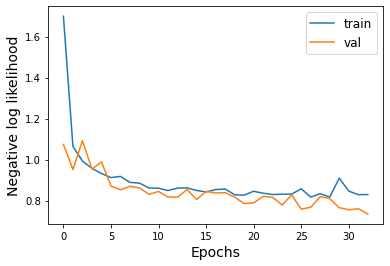

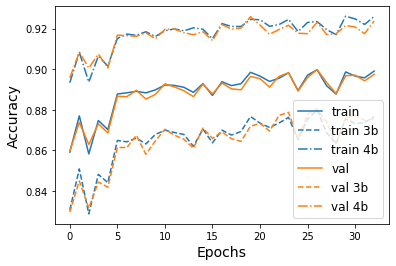

In [6]:
with open(f'{modelDir}/loss_acc.json', 'r') as loss_acc:
    metrics = json.load(loss_acc)
trainingMetrics(metrics)

Ooops - I found a bug in my function.
But honestly, this training looks fairly stable, maybe decreasing the learning rate was all that I needed?

In [7]:
np.max(metrics['train_acc_4b'])

0.9260822534561157

In [7]:
subDir = f'{physicsSample}_mc16a_PFlow-{prodTag}-{nSelectedJets}jets'
sdf = pd.read_hdf(f"../data/{subDir}/df_2b_scaledInputs.h5", key='df')

applyCuts(sdf,model,nSelectedJets)

max(njets) 5
Getting jet pts
Getting jet etas
Getting jet phis
Getting jet Es
Calculating Xwt
Calculating Xhh


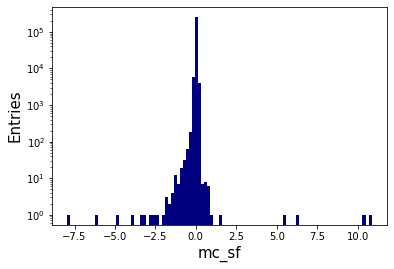

In [9]:
n,e,_ = plt.hist(sdf.loc[sdf.index %2 ==1,'mc_sf'],100,color='navy',log=True)
plt.xlabel('mc_sf',fontsize=15)
plt.ylabel('Entries',fontsize=15)
plt.show()

In [10]:
len(sdf.loc[sdf.index %2 ==1,'mc_sf'])

263792

In [11]:
np.sum(np.abs(sdf.loc[sdf.index %2 ==1,'mc_sf']) == 0 )

258

In [12]:
mu = np.mean(sdf.loc[sdf.index %2 ==1,'mc_sf'])
sigma = np.std(sdf.loc[sdf.index %2 ==1,'mc_sf'])

mu,sigma

(0.02202711811011961, 0.06378865030390655)

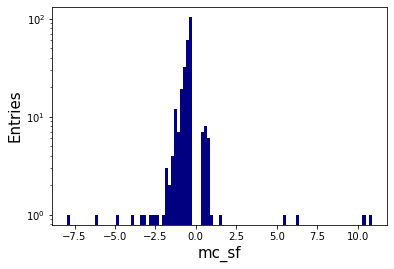

In [13]:
n,e,_ = plt.hist(sdf.loc[(sdf.index %2 ==1)&(np.abs(sdf.mc_sf-mu)/sigma > 5),'mc_sf'],100,color='navy',log=True)
plt.xlabel('mc_sf',fontsize=15)
plt.ylabel('Entries',fontsize=15)
plt.show()

Imposing a $5\sigma$ cut on the weights for training would be way too harsh.

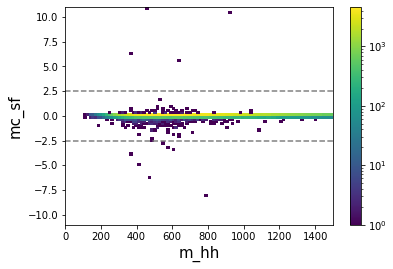

In [14]:
plt.hist2d(sdf.loc[sdf.index %2 ==1,'m_hh'],sdf.loc[sdf.index %2 ==1,'mc_sf'],
           100,[[0,1500],[-11,11]],
           norm=LogNorm())

plt.plot([0,1500],[-2.5]*2,'grey',linestyle='--')
plt.plot([0,1500],[2.5]*2,'grey',linestyle='--')

plt.xlabel('m_hh',fontsize=15)
plt.ylabel('mc_sf',fontsize=15)
plt.colorbar()

plt.show()

Oh - apply cuts should store the pairing probabilities, because this is what I want to test is how these probabilities of the chosen pair are affected by the `mc_sf`.

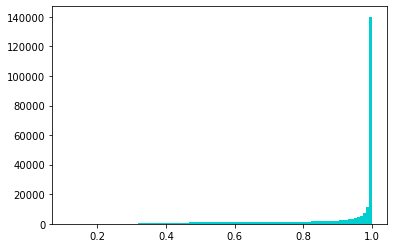

In [15]:
plt.hist(sdf.loc[sdf.index %2 ==1,'max_prob'],100,color='darkturquoise')
plt.show()

Nice - this was a *good* classifier!

Maybe separate this plot out into the cases where the predicted pair was *correct* and not?

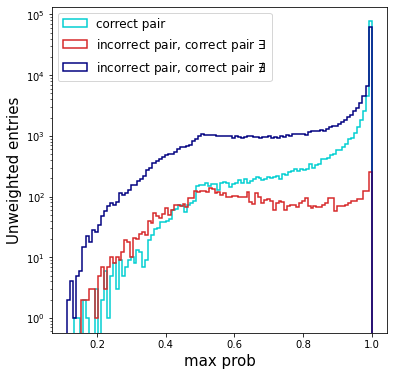

In [16]:
m0 = (sdf.index %2 ==1)&(sdf.predPair == sdf.correctPair)
m1 = (sdf.index %2 ==1)&(sdf.predPair != sdf.correctPair)&(sdf.correctPair!=-1)
m2 = (sdf.index %2 ==1)&(sdf.predPair != sdf.correctPair)&(sdf.correctPair==-1)

plt.figure(figsize=(6,6))

plt.hist(sdf.loc[m0,'max_prob'], 100,color='darkturquoise',histtype='step',log=True,
         label='correct pair',linewidth=1.5)
plt.hist(sdf.loc[m1,'max_prob'],100,color='C3',histtype='step',log=True,
         label=r'incorrect pair, correct pair $\exists$', linewidth=1.5)
plt.hist(sdf.loc[m2,'max_prob'],100,color='navy',histtype='step',log=True,
         label=r'incorrect pair, correct pair $\nexists$', linewidth=1.5)

plt.legend(loc='upper left',fontsize=12)
plt.ylabel('Unweighted entries',fontsize=15)
plt.xlabel('max prob',fontsize=15)
plt.show()

Split by 4 and 5 jet events?

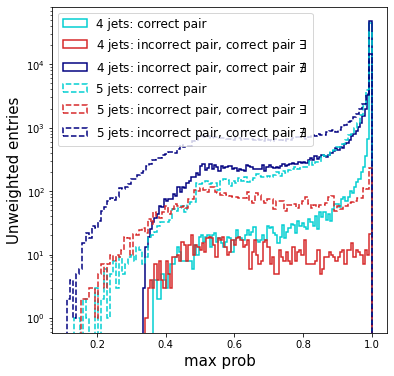

In [17]:
plt.figure(figsize=(6,6))
for nj, ls in zip([4,5],['-','--']):
    ltag = f'{nj} jets: '
    plt.hist(sdf.loc[m0 & (sdf.njets==nj),'max_prob'], 100,color='darkturquoise',histtype='step',log=True,
             label=ltag+'correct pair',linewidth=1.5,ls=ls)
    plt.hist(sdf.loc[m1 & (sdf.njets==nj),'max_prob'],100,color='C3',histtype='step',log=True,
             label=ltag+r'incorrect pair, correct pair $\exists$', linewidth=1.5,ls=ls)
    plt.hist(sdf.loc[m2 & (sdf.njets==nj),'max_prob'],100,color='navy',histtype='step',log=True,
             label=ltag+r'incorrect pair, correct pair $\nexists$', linewidth=1.5,ls=ls)

plt.legend(loc='upper left',fontsize=12)
plt.ylabel('Unweighted entries',fontsize=15)
plt.xlabel('max prob',fontsize=15)
plt.show()

*Much* more peaked for 4 jet events... interesting (and I guess not surprising).

But - I guess it doesn't super matter what the predicted probability is if it was right and the maximum?

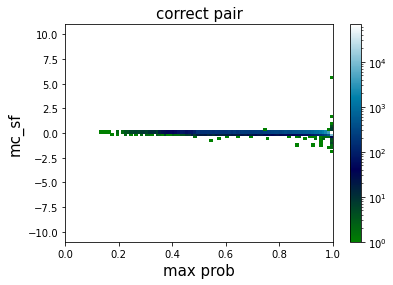

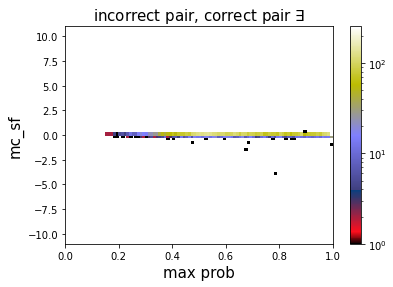

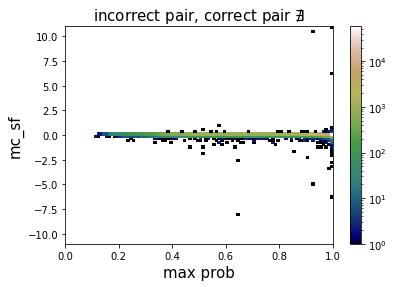

In [18]:
for mi, cmap, label in zip([m0,m1,m2],['ocean','gist_stern','gist_earth'],
                           ['correct pair', r'incorrect pair, correct pair $\exists$',
                            r'incorrect pair, correct pair $\nexists$']): 

    plt.figure()
    plt.hist2d(sdf.loc[mi,'max_prob'],sdf.loc[mi,'mc_sf'],
               100,[[0,1],[-11,11]],norm=LogNorm(),cmap=cmap)
    
    plt.colorbar()
    plt.xlabel('max prob',fontsize=15)
    plt.ylabel('mc_sf',fontsize=15)
    plt.title(label,fontsize=15)
    
plt.show()
    

Oh - I forgot about this, the events where the correct pair $\nexists$ don't enter into the training.

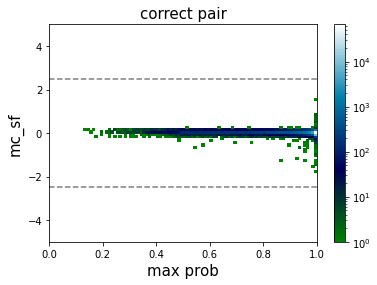

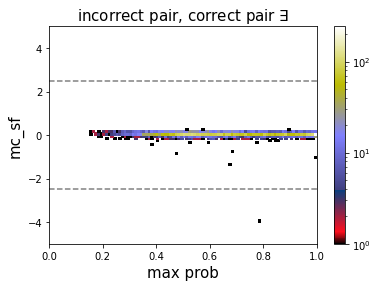

In [19]:
for mi, cmap, label in zip([m0,m1],['ocean','gist_stern'],
                           ['correct pair', r'incorrect pair, correct pair $\exists$']): 

    plt.figure()
    plt.hist2d(sdf.loc[mi,'max_prob'],sdf.loc[mi,'mc_sf'],
               100,[[0,1],[-5,5]],norm=LogNorm(),cmap=cmap)
    
    plt.colorbar()
    plt.xlabel('max prob',fontsize=15)
    plt.ylabel('mc_sf',fontsize=15)
    plt.title(label,fontsize=15)
    
    plt.plot([0,1], [2.5]*2,'grey',ls='--')
    plt.plot([0,1],[-2.5]*2,'grey',ls='--')
    
plt.show()
    

In [15]:
mhh_edg = np.linspace(0,1500,101)
mi = (sdf.index %2 ==1)&(sdf.correctPair!=-1)

p_avg = []
p_std = []

for m_start,m_end in zip(mhh_edg[:-1],mhh_edg[1:]):
    
    mask = mi & (sdf.m_hh > m_start) & (sdf.m_hh < m_end)
    
    pi = np.average(sdf.loc[mask,'max_prob'],weights=sdf.loc[mask,'mc_sf']) if np.sum(mask) > 0 else 0
    
    var = np.average((sdf.loc[mask,'max_prob']-pi)**2,weights=sdf.loc[mask,'mc_sf']) if np.sum(mask) > 0 else 0
    
    p_avg.append(pi)
    p_std.append(np.sqrt(var))
    
    if pi > 1:
        print(m_start,m_end)

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


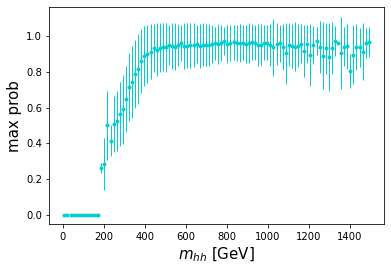

In [21]:
xx = 0.5*(mhh_edg[1:]+mhh_edg[:-1])
plt.errorbar(xx,p_avg,p_std,color='darkturquoise',linewidth=0,elinewidth=1,fmt='.')

plt.xlabel('$m_{hh}$ [GeV]',fontsize=15)
plt.ylabel('max prob',fontsize=15)
plt.show()

What's up with these events with errors larger than 1?

In [22]:
m_start, m_end = (1080.0, 1095.0)
mask = mi & (sdf.m_hh > m_start) &  (sdf.m_hh < m_end) 

num = np.sum(sdf.loc[mask,'max_prob'] * sdf.loc[mask,'mc_sf'])
den = np.sum(sdf.loc[mask,'mc_sf'])

print('num',num)
print('den',den)

num/den

num 1.6279660407455818
den 1.8009784441682675


0.903934217545515

Ok, yeah just a feature of these negative event weights... hmmm.

But also - this is *pretty cool* that we're so confident for events above 400 GeV.

**For a model trained with the usual setup, compare the loss with and without this event with the large negative weight.**

In [23]:
from preprocess import jetVars

X_tr  = np.dstack([sdf.loc[mi,['ml_j{}_{}'.format(i,v) for i in range(nSelectedJets)]].values for v in jetVars])
X_tr  = torch.from_numpy(X_tr).float()
y_tr  = torch.from_numpy(sdf.loc[mi,'correctPair'].values).long()
njets = torch.from_numpy(sdf.loc[mi,'njets'].values).long()
ws    = torch.from_numpy(sdf.loc[mi,'mc_sf'].values).float()

neg = ws < -2.5

In [24]:
import torch.nn.functional as F
from trainNet import my_nll_loss

In [25]:
njets[ws < -2.5]

tensor([4])

In [26]:
l_neg = []

for e in range(len(metrics['train_acc_4b'])):
    
    # Load in the model
    model.load_state_dict(torch.load(f'{modelDir}/model_epoch{e}.pt',map_location='cpu'))
    model.eval()
    
    # Get the loss and accuracy
    with torch.no_grad():
        
        # I checked above, this *super* negative loss was for a 4-jet event
        logit,_ = model(X_tr[ws < -2.5,:4])
        logp = F.log_softmax(logit,1).squeeze()
    
        l_neg.append((- ws[neg] * logp[y_tr[neg]]).item())
        #break

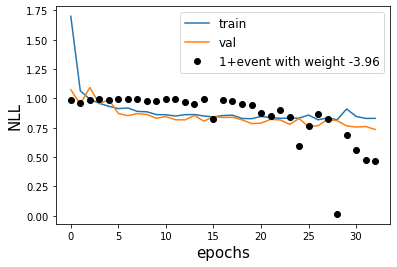

In [27]:
plt.plot(np.array(metrics['train_loss']),label='train')
plt.plot(4*np.array(metrics['val_loss']),label='val')

wi = ws[neg].squeeze().item()
plt.plot(1+.02*np.array(l_neg),'ko',label=f'1+event with weight {wi:.2f}')

plt.legend(fontsize=12)
plt.xlabel('epochs',fontsize=15)
plt.ylabel('NLL',fontsize=15)
plt.show()

**Ok - so I trained two more models**
- one cutting events with $|w_i| < 2.5$ 
- another removing events with $|w_i| < 1$.

Below are the loss curves:

In [28]:
model2 = pairAGraph(inpt_dim=5,embed_dim=embed_dim,ff_dim=ff_dim,
                    nAttnBlocks=1,nHeads=nHeads,p=dpt,njets=nSelectedJets)
modelDir2 = modelDir + '_wcut_2.5'

model2.load_state_dict(torch.load(f'{modelDir2}/model.pt',map_location='cpu'))
model2.eval()

with open(f'{modelDir2}/loss_acc.json', 'r') as loss_acc:
    metrics2 = json.load(loss_acc)

model3 = pairAGraph(inpt_dim=5,embed_dim=embed_dim,ff_dim=ff_dim,
                    nAttnBlocks=1,nHeads=nHeads,p=dpt,njets=nSelectedJets)
modelDir3 = modelDir + '_wcut_1.0'

model3.load_state_dict(torch.load(f'{modelDir3}/model.pt',map_location='cpu'))
model3.eval()

with open(f'{modelDir3}/loss_acc.json', 'r') as loss_acc:
    metrics3 = json.load(loss_acc)

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI back

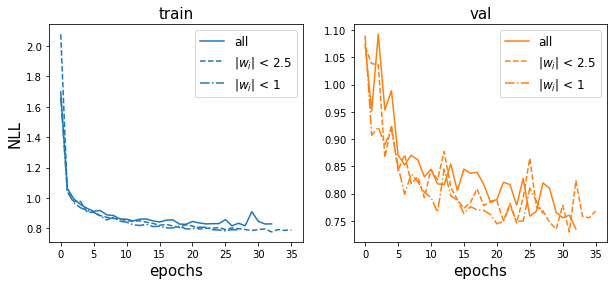

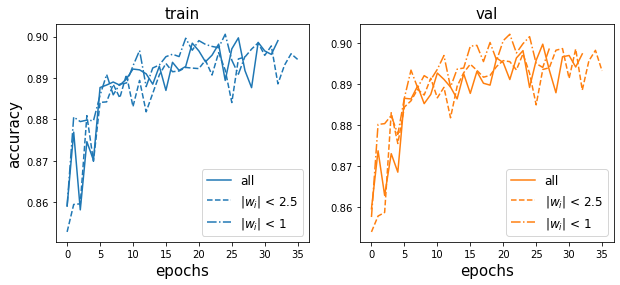

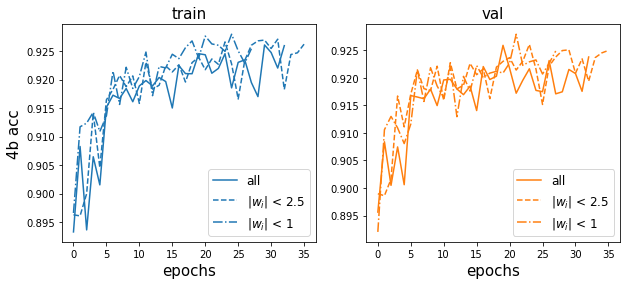

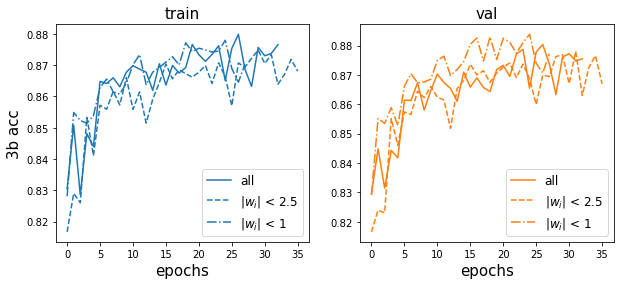

In [29]:
for metric, ylabel,f in zip(['loss','acc','acc_4b','acc_3b'],
                            ['NLL','accuracy','4b acc','3b acc'],[4,1,1,1]):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

    ax1.plot(np.array(metrics[f'train_{metric}']),label='all',color='C0')
    ax2.plot(f*np.array(metrics[f'val_{metric}']),label='all',color='C1')

    # plt.plot(np.array(l_neg)+1,'ko',label=f'1+event with weight {wi:.2f}')

    ax1.plot(np.array(metrics2[f'train_{metric}']),label='$|w_i|$ < 2.5',color='C0',ls='--')
    ax2.plot(f*np.array(metrics2[f'val_{metric}']),label='$|w_i|$ < 2.5',color='C1',ls='--')

    ax1.plot(np.array(metrics3[f'train_{metric}']),label='$|w_i|$ < 1',color='C0',ls='-.')
    ax2.plot(f*np.array(metrics3[f'val_{metric}']),label='$|w_i|$ < 1',color='C1',ls='-.')


    ax1.legend(fontsize=12)
    ax2.legend(fontsize=12)

    ax1.set_xlabel('epochs',fontsize=15)
    ax2.set_xlabel('epochs',fontsize=15)
    ax1.set_ylabel(ylabel,fontsize=15)

    ax1.set_title('train',fontsize=15)
    ax2.set_title('val',fontsize=15)
    fig.show()

$$\mathcal{L} = \sum_i w_i f_\theta (x_i)$$

I could *try* subtracting off the min value from $w_{i}$, but this changes the objective function, which I'm loath to do w/o understanding what the new objective function is optimizing with respect to.

**Another idea** If I have noisy trainings, I could just lower the learning rate?

### 2. Number of $b$-tags <a name="ntag"></a>

**Motivation:** If I include 2b in the training, hopefully it can make the reweighting easier.


In [18]:
# 2b - same params and model3
model4 = pairAGraph(inpt_dim=5,embed_dim=embed_dim,ff_dim=ff_dim,
                    nAttnBlocks=1,nHeads=nHeads,p=dpt,njets=nSelectedJets)
modelDir4 = modelDir + '_wcut_1.0_2b'

model4.load_state_dict(torch.load(f'{modelDir4}/model.pt',map_location='cpu'))
model4.eval()

with open(f'{modelDir4}/loss_acc.json', 'r') as loss_acc:
    metrics4 = json.load(loss_acc)

# Decreasing the lr
model5 = pairAGraph(inpt_dim=5,embed_dim=embed_dim,ff_dim=ff_dim,
                    nAttnBlocks=1,nHeads=nHeads,p=dpt,njets=nSelectedJets)

lr5 = .005
xformerDir5 = f'xformer_{nLayers}layers_dim{embed_dim}_ff{ff_dim}_{nHeads}heads_dpt{dpt}_jetCompatibility_lr{lr5}_batch2048_mask'
modelDir5 = f"models/{physicsSample}_mc16ade_PFlow-{prodTag}-{nSelectedJets}jets/{xformerDir5}_wcut_1.0_2b"

model5.load_state_dict(torch.load(f'{modelDir5}/model.pt',map_location='cpu'))
model5.eval()

with open(f'{modelDir5}/loss_acc.json', 'r') as loss_acc:
    metrics5 = json.load(loss_acc)

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI back

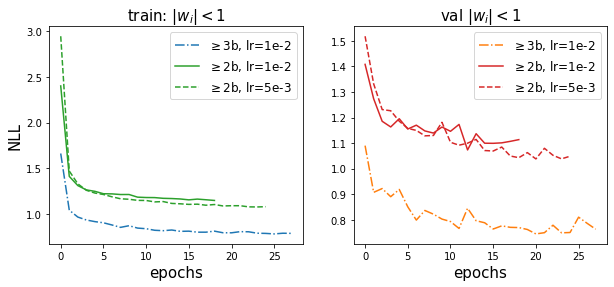

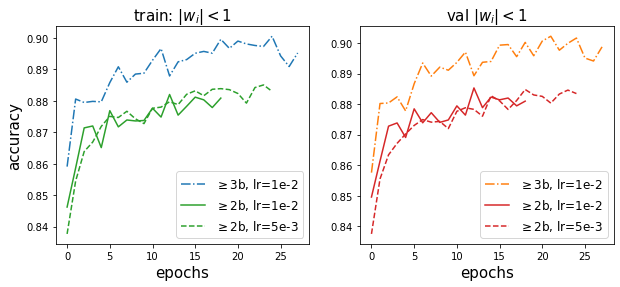

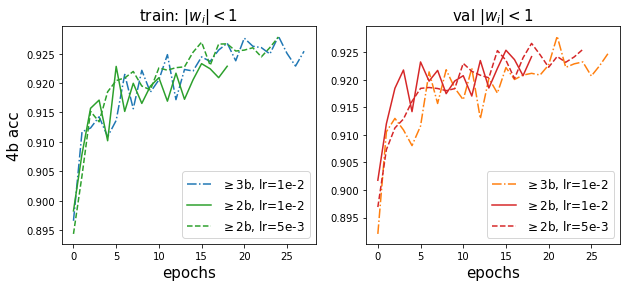

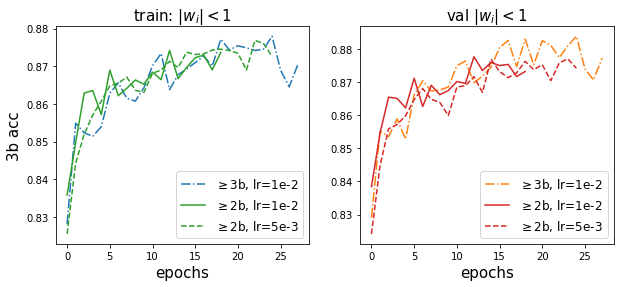

In [31]:
for metric, ylabel,f in zip(['loss','acc','acc_4b','acc_3b'],
                            ['NLL','accuracy','4b acc','3b acc'],[4,1,1,1]):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

    ax1.plot(np.array(metrics3[f'train_{metric}']),label='$\geq$3b, lr=1e-2',color='C0',ls='-.')
    ax2.plot(f*np.array(metrics3[f'val_{metric}']),label='$\geq$3b, lr=1e-2',color='C1',ls='-.')

    ax1.plot(np.array(metrics4[f'train_{metric}']),label='$\geq$2b, lr=1e-2',color='C2',ls='-')
    ax2.plot(f*np.array(metrics4[f'val_{metric}']),label='$\geq$2b, lr=1e-2',color='C3',ls='-')

    ax1.plot(np.array(metrics5[f'train_{metric}']),label='$\geq$2b, lr=5e-3',color='C2',ls='--')
    ax2.plot(f*np.array(metrics5[f'val_{metric}']),label='$\geq$2b, lr=5e-3',color='C3',ls='--')

    ax1.legend(fontsize=12)
    ax2.legend(fontsize=12)

    ax1.set_xlabel('epochs',fontsize=15)
    ax2.set_xlabel('epochs',fontsize=15)
    ax1.set_ylabel(ylabel,fontsize=15)

    ax1.set_title('train: $|w_i| < 1$',fontsize=15)
    ax2.set_title('val $|w_i| < 1$',fontsize=15)
    fig.show()

Plan: let's compare the accuracies, $m_{hh}$ and proportion of signal *inside* the SR.

(If it's at all comparable, I'll go with this for the ...)

In [8]:
# subDir = f'{physicsSample}_mc16a_PFlow-{prodTag}-{nSelectedJets}jets'
# sdf = pd.read_hdf(f"../data/{subDir}/df_3b_scaledInputs.h5", key='df')
#sdf = df[df.index % 2 == 0]

# Since I'm only using half the stats for the test set, need to multiply L by 2.
key = f'{physicsSample}_mc16a_PFlow-{prodTag}'
print(key)
L = 24.5556
normalizeWeight(sdf,key,lumi=L*2)

SMNR_mc16a_PFlow-MAR2020
/u/ki/nhartman/gpfs/public/hh4b/SMNR/user.jagrundy.HH4B.450000.SM_HH.MC16a-2015-2016.AB21.2.91-MAR20-0.full_MiniNTuple.root/user.jagrundy.20736236._000001.MiniNTuple.root
sum_weights_initial 26458.62742272562
xsec 27.47
k_factor 1.13
gen_filter_eff 0.3392
sample_weight 0.019543672735207792


In [19]:
applyCuts(sdf,model5,nSelectedJets)

max(njets) 5


RuntimeError: [enforce fail at CPUAllocator.cpp:64] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 82982720 bytes. Error code 12 (Cannot allocate memory)


In [17]:
sdf['abs_deta_hh'] = np.abs(sdf.eta_h1 - sdf.eta_h2)

SR center: (120.0,110.0) GeV


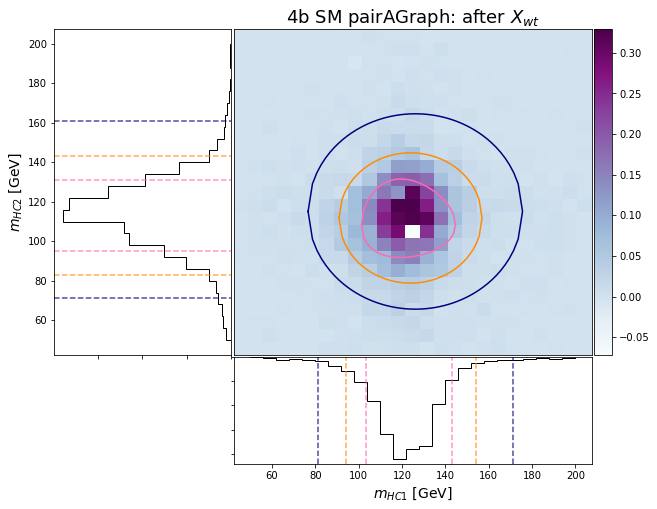

In [35]:
kwargs = {'figsize': (10, 8),
           'bins' : (25,25),
           'xrange': (50, 200),
           'yrange': (50, 200),
           'xhisttype': 'step',
           'yhisttype': 'step',
           'cmap': 'BuPu',
           'title': '4b SM pairAGraph: after $X_{wt}$',
           'xlabel': '$m_{HC1}$ [GeV]',
           'ylabel': '$m_{HC2}$ [GeV]',
           'axis_hist_on': True,
           'hist_color': 'black',
           'alpha': 0.7,
           'save': False,
           'show': True
          }

smask0 = (sdf.index%2==0) & (sdf.ntag >= 4)&(sdf.trigger) & (sdf.abs_deta_hh < 1.5) & (sdf.X_wt > 1.5)
kwargs['weights'] = sdf.loc[smask0,'mc_sf']
fig = massplane(sdf.loc[smask0,'m_h1'],
                sdf.loc[smask0,'m_h2'],**kwargs)

Compare w/ the # of signal events if we *shift* the center.

In [ ]:
from analysis import getXhh

In [37]:
HC1 = TLorentzVectorArray.from_ptetaphim(sdf.pT_h1,sdf.eta_h1,sdf.phi_h1,sdf.m_h1)
HC2 = TLorentzVectorArray.from_ptetaphim(sdf.pT_h2,sdf.eta_h2,sdf.phi_h2,sdf.m_h2)

In [38]:
c1,c2 = 122,114.3
sdf['new_Xhh'] = getXhh(HC1,HC2,c1,c2)

In [39]:
np.sum(sdf.loc[smask0 & (sdf.new_Xhh < 1.6),'mc_sf'])

6.29468347198739

Awesome - so now I have approximately the proportion of the signal events that I was expecting. 

**Load in the background dfs**

In [11]:
reload = False

In [12]:
filename_3b = '../data/data16_PFlow-FEB20-5jets/df_train_2b_3b.h5'

if reload:
    dfs = []
    for f in tqdm(glob('../data/data16_PFlow-FEB20-5jets/files/df_period?_*_train_2b_3b.h5')):
        dfi = pd.read_hdf(f,key='df')
        dfs.append(dfi)

    bdf_4b = pd.concat(dfs)
    
    bdf_4b.to_hdf(filename_3b,key='df')
    
else:
    bdf_4b = pd.read_hdf(filename_3b,key='df')
    

In [13]:
filename_2b = '../data/data16_PFlow-FEB20-5jets/df_train_2b_2b.h5'

if reload:
    dfs = []
    for f in tqdm(glob('../data/data16_PFlow-FEB20-5jets/files/df_period?_*_train_2b_2b.h5')):
        dfi = pd.read_hdf(f,key='df')
        dfs.append(dfi)

    bdf_2b = pd.concat(dfs)
    
    bdf_2b.to_hdf(filename_2b,key='df')
    
else:
    bdf_2b = pd.read_hdf(filename_2b,key='df')
    

MemoryError: Unable to allocate 12.6 GiB for an array with shape (56437409, 30) and data type float64

**Compare rw variables before reweighting**

In [43]:
bdf_2b.columns

Index(['run_number', 'event_number', 'mc_sf', 'ntag', 'njets',
       'kinematic_region', 'm_hh', 'pt_hh', 'X_wt', 'm_hh_cor', 'pT_h1',
       'eta_h1', 'phi_h1', 'm_h1', 'dRjj_h1', 'pT_h2', 'eta_h2', 'phi_h2',
       'm_h2', 'dRjj_h2', 'pT_2', 'pT_4', 'eta_i', 'dRjj_1', 'dRjj_2',
       'cosThetaStar', 'cosTheta1', 'cosTheta2', 'Phi', 'Phi1', 'ml_j0_Db',
       'ml_j1_Db', 'ml_j2_Db', 'ml_j3_Db', 'ml_j4_Db', 'HT', 'MDR', 'MDpT',
       'max_prob'],
      dtype='object')

In [ ]:
for bdf in [bdf_2b,bdf_4b]:
    bdf['abs_deta_hh'] = np.abs(bdf.eta_h1-bdf.eta_h2)
    bdf['cut_deta_hh'] = (bdf.abs_deta_hh < 1.5) 
    bdf['cut_Xwt'] = (bdf.X_wt > 1.5) 
    
    HC1 = TLorentzVectorArray.from_ptetaphim(bdf.pT_h1, bdf.eta_h1, bdf.phi_h1, bdf.m_h1)
    HC2 = TLorentzVectorArray.from_ptetaphim(bdf.pT_h2, bdf.eta_h2, bdf.phi_h2, bdf.m_h2)
    bdf['new_Xhh'] = getXhh(HC1,HC2,c1,c2)

In [45]:
rw_vars = ['njets','pT_4', 'pT_2', 'dRjj_1', 'dRjj_2','eta_i','pt_hh','m_hh']
nBins = [4]+[50]*7
myRanges = [(3.5,7.5),(0,125),(0,200),(0,4),(0,4),(0,2.5),(0,400),(0,1000)]

In [46]:
dataText = "$\mathbf{ATLAS}$ data Internal\n"
dataText += "2016 data FEB2020 MNT prod\n"
dataText += "DL1r 77% WP with pairAGraph"

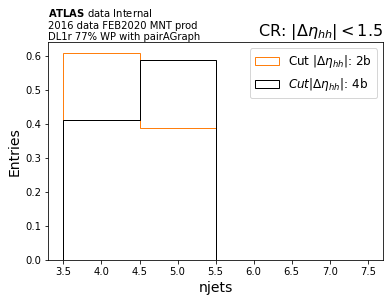

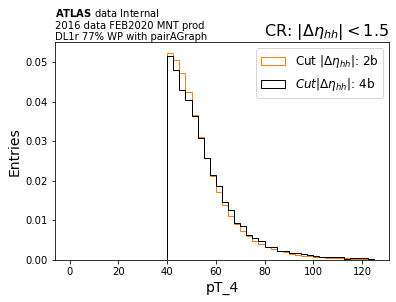

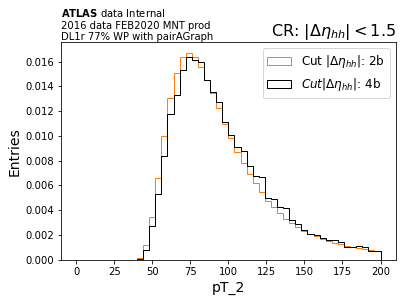

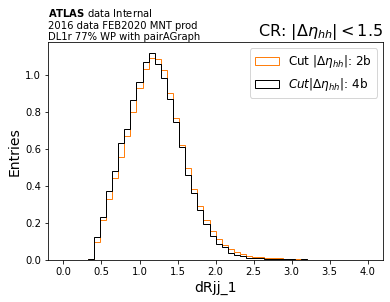

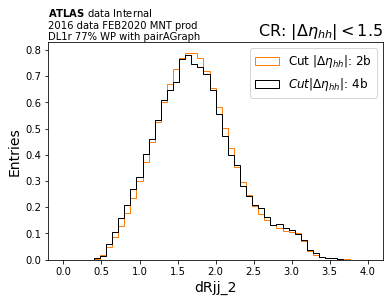

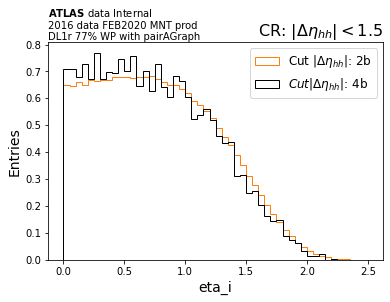

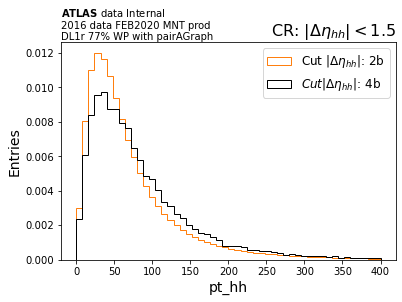

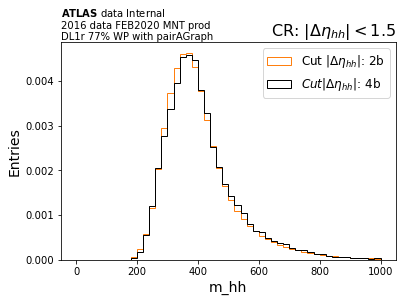

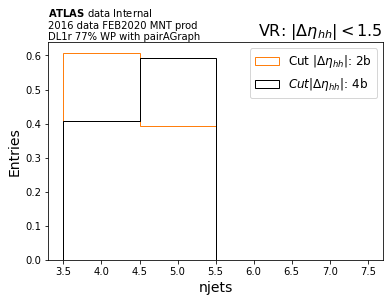

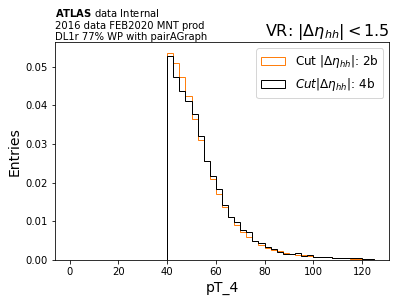

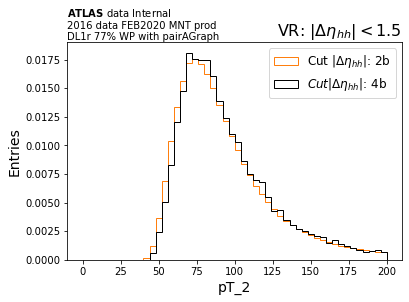

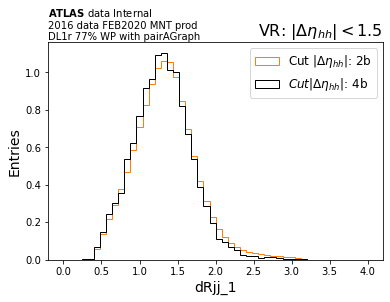

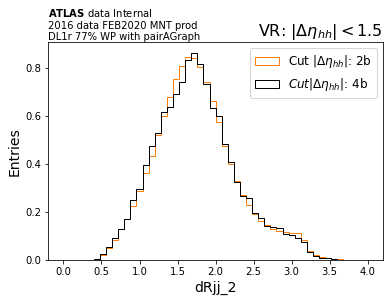

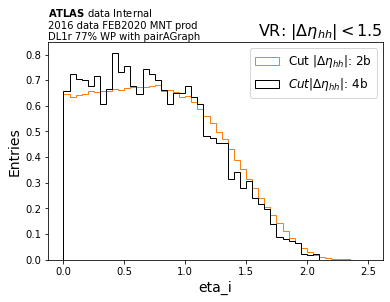

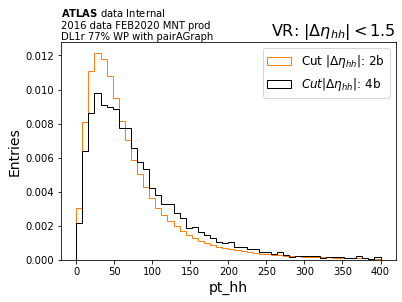

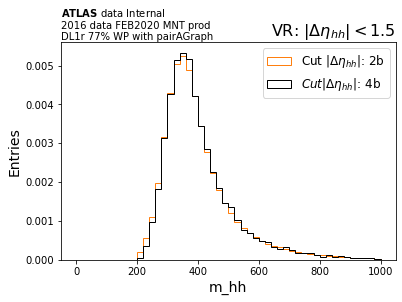

In [47]:
for region, tag in zip([2,1],['CR','VR']):

    mask_2b = (bdf_2b.kinematic_region==region)
    mask_4b = (bdf_4b.ntag>=4) & (bdf_4b.kinematic_region==region)
    
    for c,n,r in zip(rw_vars,nBins,myRanges):

        plt.figure()
        plt.hist(bdf_2b.loc[mask_2b & (bdf_2b.abs_deta_hh < 1.5),c], 
                 n, r, color='C1',density=True,
                 histtype='step',label='Cut $|\Delta \eta_{hh}|$: 2b')

        plt.hist(bdf_4b.loc[mask_4b & (bdf_4b.abs_deta_hh < 1.5),c],
                 n,r,color='k',density=True,
                 histtype='step',label='$Cut |\Delta \eta_{hh}|$: 4b')

        plt.xlabel(c,fontsize=14)
        plt.ylabel('Entries',fontsize=14)
        plt.legend(fontsize=12,loc='best')
        plt.title(tag+': $|\Delta \eta_{hh}|<1.5$',loc='right',fontsize=16)

        ax = plt.gca()
        plt.text(0,1,dataText,ha='left',va='bottom',transform=ax.transAxes)

        #plt.savefig(f'figures/dl1r_77/rw_figs/{c}_cf_deta_hh_cut.pdf',bbox_inches='tight')
        plt.show()

Ok - wow, this ended up being *a lot* better than I was anticipating. What's the scaled $s/\sqrt{b}$?

In [48]:
edges = np.array([150, 250, 262, 275, 288, 302, 317, 332, 348, 365, 383, 402, 422, 443, 465, 488, 512, 
                  537, 563, 591, 620, 651, 683, 717, 752, 789, 828, 869, 912, 957,1004, 1054, 1106, 1161, 
                  1219, 1279, 1342, 1409, 1479, 1552, 1629, 1710, 1795, 1884, 1978, 2076])

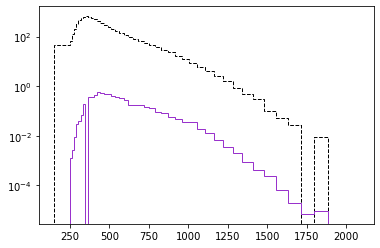

In [49]:
SR_2b = (bdf_2b.X_wt > 1.5) & (bdf_2b.kinematic_region==0) & (bdf_2b['abs_deta_hh'] < 1.5)

N2b = np.sum((bdf_2b.kinematic_region==2) & (bdf_2b.abs_deta_hh < 1.5))
N4b = np.sum((bdf_4b.ntag>=4) & (bdf_4b.kinematic_region==2) & (bdf_4b.abs_deta_hh < 1.5))

N = N4b/N2b

b,_,_ = plt.hist(bdf_2b.loc[SR_2b,'m_hh'],edges,
                 weights=np.ones(np.sum(SR_2b))*N,log=True,
                 color='k',histtype='step',linestyle='--')

smask = (sdf.index%2==0)&(sdf.ntag>=4)&(sdf.trigger) & (sdf.abs_deta_hh < 1.5) & (sdf.X_wt > 1.5) & (sdf.kinematic_region == 0)
s,e,_ = plt.hist(sdf.loc[smask,'m_hh'],edges,
                 weights=sdf.loc[smask,'mc_sf'],
         color='darkorchid',histtype='step',log=True)

plt.show()

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


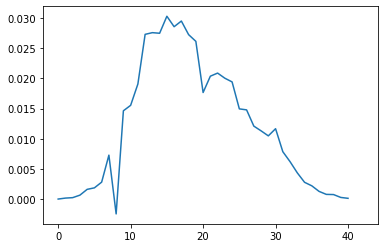

In [50]:
plt.plot(s/np.sqrt(b))

In [51]:
np.sqrt(np.sum(s[b!=0]**2/b[b!=0]))

0.10104331924089043

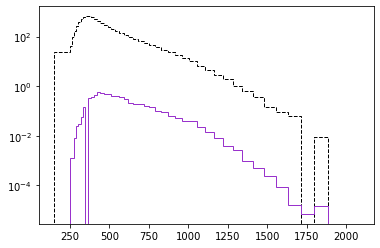

In [52]:
SR_2b = (bdf_2b.X_wt > 1.5) & (bdf_2b.new_Xhh<1.6) & (bdf_2b['abs_deta_hh'] < 1.5)

b,_,_ = plt.hist(bdf_2b.loc[SR_2b,'m_hh'],edges,
                 weights=np.ones(np.sum(SR_2b))*N,log=True,
                 color='k',histtype='step',linestyle='--')

smask = (sdf.index%2==0)&(sdf.ntag>=4)&(sdf.trigger)&(sdf.abs_deta_hh<1.5)&(sdf.X_wt>1.5)&(sdf.new_Xhh<1.6)
s,e,_ = plt.hist(sdf.loc[smask,'m_hh'],edges,
                 weights=sdf.loc[smask,'mc_sf'],
         color='darkorchid',histtype='step',log=True)

plt.show()

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


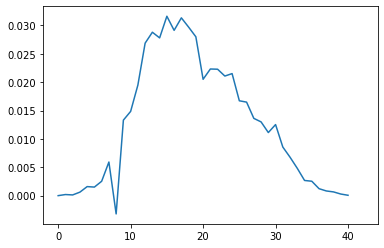

In [53]:
plt.plot(s/np.sqrt(b))

In [54]:
np.sqrt(np.sum(s[b!=0]**2/b[b!=0]))

0.10641914574282231

In [55]:
np.sqrt(np.sum(s[(b!=0)&(s >0)]**2/b[(b!=0)&(s >0)]))

0.10637040480106472

In [56]:
.108/.103

1.0485436893203883

In [57]:
6.3/6

1.05

Ok - this was *not* a big difference, but at least it's *comparable* to what I expected with the increase in signal.

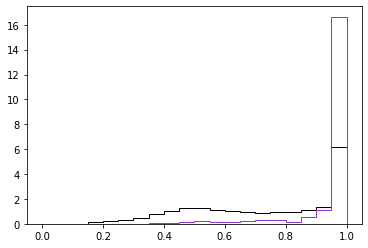

In [58]:
plt.hist(bdf_2b.loc[SR_2b,'max_prob'],20,(0,1),histtype='step',color='k',density=True)
plt.hist(sdf.loc[smask,'max_prob'],20,(0,1),weights=sdf.loc[smask,'mc_sf'],
         histtype='step',color='darkorchid',density=True)
plt.show()

In [59]:
N2b = np.sum(bdf_2b.loc[(bdf_2b.kinematic_region==2) & (bdf_2b.abs_deta_hh < 1.5),'max_prob'])
N4b = np.sum(bdf_4b.loc[(bdf_4b.ntag>=4) & (bdf_4b.kinematic_region==2) & (bdf_4b.abs_deta_hh < 1.5),'max_prob'])

N = N4b/N2b
N

0.009802232

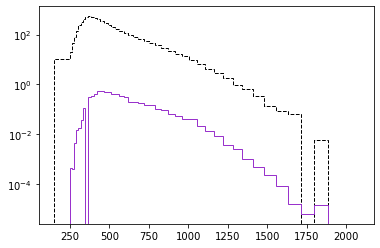

In [60]:
SR_2b = (bdf_2b.X_wt > 1.5) & (bdf_2b.new_Xhh<1.6) & (bdf_2b['abs_deta_hh'] < 1.5)

b,_,_ = plt.hist(bdf_2b.loc[SR_2b,'m_hh'],edges,
                 weights=bdf_2b.loc[SR_2b,'max_prob']*N,log=True,
                 color='k',histtype='step',linestyle='--')

smask = (sdf.index%2==0)&(sdf.ntag>=4)&(sdf.trigger)&(sdf.abs_deta_hh<1.5)&(sdf.X_wt>1.5)&(sdf.new_Xhh<1.6)
s,e,_ = plt.hist(sdf.loc[smask,'m_hh'],edges,
                 weights=sdf.loc[smask,'mc_sf']*sdf.loc[smask,'max_prob'],
         color='darkorchid',histtype='step',log=True)

plt.show()

In [61]:
np.sum(b),np.sum(s)

(5765.59814453125, 6.038976395937333)

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


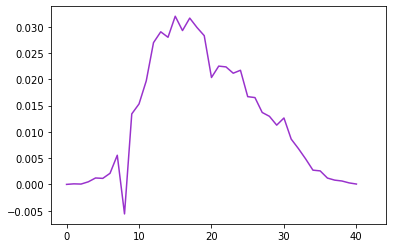

In [62]:
plt.plot(s/np.sqrt(b),color='darkorchid')

In [63]:
np.sqrt(np.sum(s[(b!=0)&(s >0)]**2/b[(b!=0)&(s >0)]))

0.10702245297886462

Maybe look the `max_prob` as a function of the massplane and $m_{hh}$, because then I could *cut* on it, like the recent ATLAS $m_t$ measurement did?

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


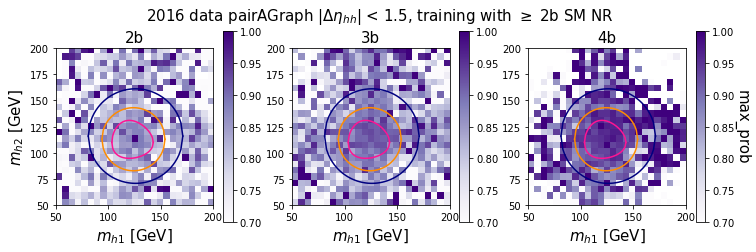

In [64]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,3.5))

#2b
s_2b = (sdf.index%2==0) & (sdf.ntag==2) & (sdf.trigger) & (sdf.abs_deta_hh < 1.5)

num,_,_ = np.histogram2d(sdf.loc[s_2b,'m_h1'],sdf.loc[s_2b,'m_h2'],
                         25,[[50,200],[50,200]],
                         weights=sdf.loc[s_2b,'max_prob']*sdf.loc[s_2b,'mc_sf'])
den,_,_ = np.histogram2d(sdf.loc[s_2b,'m_h1'],sdf.loc[s_2b,'m_h2'],
                         25,[[50,200],[50,200]],weights=sdf.loc[s_2b,'mc_sf'])

ns_2b = num / den


i = ax1.imshow(ns_2b.T[::-1],cmap='Purples',extent=[50,200,50,200],vmin=0.7,vmax=1)
fig.colorbar(i,ax=ax1)
ax1.set_xlabel('$m_{h1}$ [GeV]',fontsize=15)
ax1.set_ylabel('$m_{h2}$ [GeV]',fontsize=15)
ax1.set_title('2b',fontsize=15)

ax1.plot(SR_x,SR_y1,'deeppink')
ax1.plot(SR_x,SR_y2,'deeppink')
ax1.plot(CR_x,CR_y1,'darkorange')
ax1.plot(CR_x,CR_y2,'darkorange')
ax1.plot(SB_x,SB_y1,'navy')
ax1.plot(SB_x,SB_y2,'navy')

#3b
s_3b = (sdf.index%2==0) & (sdf.ntag==3) & (sdf.trigger) & (sdf.abs_deta_hh < 1.5)  

num,_,_ = np.histogram2d(sdf.loc[s_3b,'m_h1'],sdf.loc[s_3b,'m_h2'],
                         25,[[50,200],[50,200]],
                         weights=sdf.loc[s_3b,'max_prob']*sdf.loc[s_3b,'mc_sf'])
den,_,_ = np.histogram2d(sdf.loc[s_3b,'m_h1'],sdf.loc[s_3b,'m_h2'],
                         25,[[50,200],[50,200]],weights=sdf.loc[s_3b,'mc_sf'])

ns_3b = num / den


i = ax2.imshow(ns_3b.T[::-1],cmap='Purples',extent=[50,200,50,200],vmin=0.7,vmax=1)
fig.colorbar(i,ax=ax2)
ax2.set_xlabel('$m_{h1}$ [GeV]',fontsize=15)
ax2.set_title('3b',fontsize=15)

ax2.plot(SR_x,SR_y1,'deeppink')
ax2.plot(SR_x,SR_y2,'deeppink')
ax2.plot(CR_x,CR_y1,'darkorange')
ax2.plot(CR_x,CR_y2,'darkorange')
ax2.plot(SB_x,SB_y1,'navy')
ax2.plot(SB_x,SB_y2,'navy')

# 4b
s_4b = (sdf.index%2==0) & (sdf.ntag>=4) & (sdf.trigger) & (sdf.abs_deta_hh < 1.5) 

num,_,_ = np.histogram2d(sdf.loc[s_4b,'m_h1'],sdf.loc[s_4b,'m_h2'],
                         25,[[50,200],[50,200]],
                         weights=sdf.loc[s_4b,'max_prob']*sdf.loc[s_4b,'mc_sf'])
den,_,_ = np.histogram2d(sdf.loc[s_4b,'m_h1'],sdf.loc[s_4b,'m_h2'],
                         25,[[50,200],[50,200]],weights=sdf.loc[s_4b,'mc_sf'])

ns_4b = num / den


i = ax3.imshow(ns_4b.T[::-1],cmap='Purples',extent=[50,200,50,200],vmin=0.7,vmax=1)
cbar = fig.colorbar(i,ax=ax3)
cbar.set_label('max_prob',rotation=270,labelpad=15,fontsize=15)

ax3.set_xlabel('$m_{h1}$ [GeV]',fontsize=15)
ax3.set_title('4b',fontsize=15)

ax3.plot(SR_x,SR_y1,'deeppink')
ax3.plot(SR_x,SR_y2,'deeppink')
ax3.plot(CR_x,CR_y1,'darkorange')
ax3.plot(CR_x,CR_y2,'darkorange')
ax3.plot(SB_x,SB_y1,'navy')
ax3.plot(SB_x,SB_y2,'navy')

fig.suptitle('2016 data pairAGraph $|\Delta \eta_{hh}|$ < 1.5, training with $\geq$ 2b SM NR',fontsize=15)

plt.show()

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


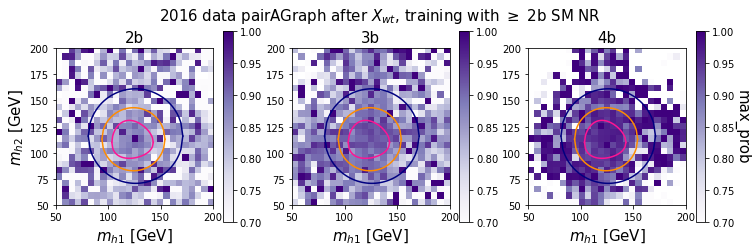

In [65]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,3.5))

#2b
s_2b = (sdf.index%2==0) & (sdf.ntag==2) & (sdf.trigger) & (sdf.abs_deta_hh < 1.5) & (sdf.X_wt > 1.5) 

num,_,_ = np.histogram2d(sdf.loc[s_2b,'m_h1'],sdf.loc[s_2b,'m_h2'],
                         25,[[50,200],[50,200]],
                         weights=sdf.loc[s_2b,'max_prob']*sdf.loc[s_2b,'mc_sf'])
den,_,_ = np.histogram2d(sdf.loc[s_2b,'m_h1'],sdf.loc[s_2b,'m_h2'],
                         25,[[50,200],[50,200]],weights=sdf.loc[s_2b,'mc_sf'])

ns_2b = num / den


i = ax1.imshow(ns_2b.T[::-1],cmap='Purples',extent=[50,200,50,200],vmin=0.7,vmax=1)
fig.colorbar(i,ax=ax1)
ax1.set_xlabel('$m_{h1}$ [GeV]',fontsize=15)
ax1.set_ylabel('$m_{h2}$ [GeV]',fontsize=15)
ax1.set_title('2b',fontsize=15)

ax1.plot(SR_x,SR_y1,'deeppink')
ax1.plot(SR_x,SR_y2,'deeppink')
ax1.plot(CR_x,CR_y1,'darkorange')
ax1.plot(CR_x,CR_y2,'darkorange')
ax1.plot(SB_x,SB_y1,'navy')
ax1.plot(SB_x,SB_y2,'navy')

#3b
s_3b = (sdf.index%2==0) & (sdf.ntag==3) & (sdf.trigger) & (sdf.abs_deta_hh < 1.5) & (sdf.X_wt > 1.5) 

num,_,_ = np.histogram2d(sdf.loc[s_3b,'m_h1'],sdf.loc[s_3b,'m_h2'],
                         25,[[50,200],[50,200]],
                         weights=sdf.loc[s_3b,'max_prob']*sdf.loc[s_3b,'mc_sf'])
den,_,_ = np.histogram2d(sdf.loc[s_3b,'m_h1'],sdf.loc[s_3b,'m_h2'],
                         25,[[50,200],[50,200]],weights=sdf.loc[s_3b,'mc_sf'])

ns_3b = num / den


i = ax2.imshow(ns_3b.T[::-1],cmap='Purples',extent=[50,200,50,200],vmin=0.7,vmax=1)
fig.colorbar(i,ax=ax2)
ax2.set_xlabel('$m_{h1}$ [GeV]',fontsize=15)
ax2.set_title('3b',fontsize=15)

ax2.plot(SR_x,SR_y1,'deeppink')
ax2.plot(SR_x,SR_y2,'deeppink')
ax2.plot(CR_x,CR_y1,'darkorange')
ax2.plot(CR_x,CR_y2,'darkorange')
ax2.plot(SB_x,SB_y1,'navy')
ax2.plot(SB_x,SB_y2,'navy')

# 4b
s_4b = (sdf.index%2==0) & (sdf.ntag>=4) & (sdf.trigger) & (sdf.abs_deta_hh < 1.5) & (sdf.X_wt > 1.5) 

num,_,_ = np.histogram2d(sdf.loc[s_4b,'m_h1'],sdf.loc[s_4b,'m_h2'],
                         25,[[50,200],[50,200]],
                         weights=sdf.loc[s_4b,'max_prob']*sdf.loc[s_4b,'mc_sf'])
den,_,_ = np.histogram2d(sdf.loc[s_4b,'m_h1'],sdf.loc[s_4b,'m_h2'],
                         25,[[50,200],[50,200]],weights=sdf.loc[s_4b,'mc_sf'])

ns_4b = num / den


i = ax3.imshow(ns_4b.T[::-1],cmap='Purples',extent=[50,200,50,200],vmin=0.7,vmax=1)
cbar = fig.colorbar(i,ax=ax3)
cbar.set_label('max_prob',rotation=270,labelpad=15,fontsize=15)

ax3.set_xlabel('$m_{h1}$ [GeV]',fontsize=15)
ax3.set_title('4b',fontsize=15)

ax3.plot(SR_x,SR_y1,'deeppink')
ax3.plot(SR_x,SR_y2,'deeppink')
ax3.plot(CR_x,CR_y1,'darkorange')
ax3.plot(CR_x,CR_y2,'darkorange')
ax3.plot(SB_x,SB_y1,'navy')
ax3.plot(SB_x,SB_y2,'navy')

fig.suptitle('2016 data pairAGraph after $X_{wt}$, training with $\geq$ 2b SM NR',fontsize=15)

plt.show()

Ok - my *biggest* take aways from these two plots are 
1. This `max_prob` is consistently larger for 4b than it is for 2b and 3b.
2. It does seem to be pretty flat in the massplane though.

So doing something like requiring `max_prob` > .85 should keep most of the signal.

Awesome - and now for data!

**Before $X_{wt}$**

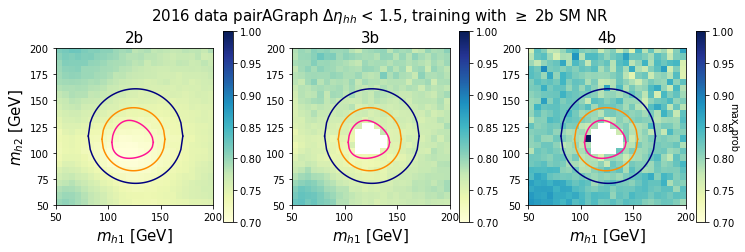

In [66]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,3.5))

# 2b
mask_2b = (bdf_2b['abs_deta_hh'] < 1.5)

nb_2b,_,_,_ = binned_statistic_2d(bdf_2b.loc[mask_2b,'m_h1'], bdf_2b.loc[mask_2b,'m_h2'],
                               bdf_2b.loc[mask_2b,'max_prob'],bins=25,range=[[50,200],[50,200]])

i = ax1.imshow(nb_2b.T[::-1],cmap='YlGnBu',extent=[50,200,50,200],vmin=.7,vmax=1)
fig.colorbar(i,ax=ax1)

ax1.plot(SR_x,SR_y1,'deeppink')
ax1.plot(SR_x,SR_y2,'deeppink')
ax1.plot(CR_x,CR_y1,'darkorange')
ax1.plot(CR_x,CR_y2,'darkorange')
ax1.plot(SB_x,SB_y1,'navy')
ax1.plot(SB_x,SB_y2,'navy')


ax1.set_xlabel('$m_{h1}$ [GeV]',fontsize=15)
ax1.set_ylabel('$m_{h2}$ [GeV]',fontsize=15)
ax1.set_title('2b',fontsize=15)


# 3b
mask_3b = (bdf_4b['abs_deta_hh'] < 1.5) & (bdf_4b['ntag'] == 3) & (bdf_4b.kinematic_region!=0)

nb_3b,_,_,_ = binned_statistic_2d(bdf_4b.loc[mask_3b,'m_h1'], bdf_4b.loc[mask_3b,'m_h2'],
                                  bdf_4b.loc[mask_3b,'max_prob'],bins=25,range=[[50,200],[50,200]])

i = ax2.imshow(nb_3b.T[::-1],cmap='YlGnBu',extent=[50,200,50,200],vmin=.7,vmax=1)
fig.colorbar(i,ax=ax2)

ax2.plot(SR_x,SR_y1,'deeppink')
ax2.plot(SR_x,SR_y2,'deeppink')
ax2.plot(CR_x,CR_y1,'darkorange')
ax2.plot(CR_x,CR_y2,'darkorange')
ax2.plot(SB_x,SB_y1,'navy')
ax2.plot(SB_x,SB_y2,'navy')

ax2.set_xlabel('$m_{h1}$ [GeV]',fontsize=15)
ax2.set_title('3b',fontsize=15)

# # 4b
mask_4b = (bdf_4b['abs_deta_hh'] < 1.5) & (bdf_4b['ntag'] >= 4) & (bdf_4b.kinematic_region!=0)

nb_4b,_,_,_ = binned_statistic_2d(bdf_4b.loc[mask_4b,'m_h1'], bdf_4b.loc[mask_4b,'m_h2'],
                                  bdf_4b.loc[mask_4b,'max_prob'],bins=25,range=[[50,200],[50,200]])

i = ax3.imshow(nb_4b.T[::-1],cmap='YlGnBu',extent=[50,200,50,200],vmin=.7,vmax=1)
cbar = fig.colorbar(i,ax=ax3)
cbar.set_label('max_prob',rotation=270)

ax3.plot(SR_x,SR_y1,'deeppink')
ax3.plot(SR_x,SR_y2,'deeppink')
ax3.plot(CR_x,CR_y1,'darkorange')
ax3.plot(CR_x,CR_y2,'darkorange')
ax3.plot(SB_x,SB_y1,'navy')
ax3.plot(SB_x,SB_y2,'navy')

ax3.set_xlabel('$m_{h1}$ [GeV]',fontsize=15)
ax3.set_title('4b',fontsize=15)

fig.suptitle('2016 data pairAGraph $\Delta \eta_{hh}$ < 1.5, training with $\geq$ 2b SM NR',fontsize=15)

plt.show()

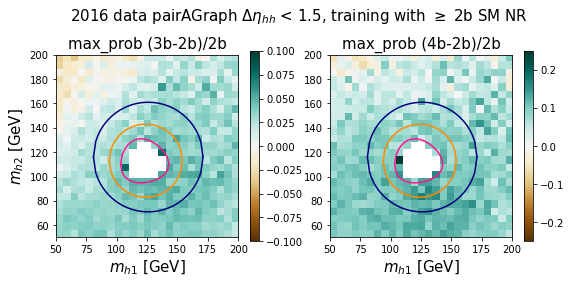

In [67]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(9,3.5))

closure_deta_3b = (nb_3b-nb_2b)/nb_2b
i = ax1.imshow(closure_deta_3b.T[::-1],cmap='BrBG',extent=[50,200,50,200],vmin=-.1,vmax=.1)
fig.colorbar(i,ax=ax1)

ax1.plot(SR_x,SR_y1,'deeppink')
ax1.plot(SR_x,SR_y2,'deeppink')
ax1.plot(CR_x,CR_y1,'darkorange')
ax1.plot(CR_x,CR_y2,'darkorange')
ax1.plot(SB_x,SB_y1,'navy')
ax1.plot(SB_x,SB_y2,'navy')

ax1.set_xlabel('$m_{h1}$ [GeV]',fontsize=15)
ax1.set_ylabel('$m_{h2}$ [GeV]',fontsize=15)
ax1.set_title('max_prob (3b-2b)/2b',fontsize=15)


closure_deta_4b = (nb_4b-nb_2b)/nb_2b
i = ax2.imshow(closure_deta_4b.T[::-1],cmap='BrBG',extent=[50,200,50,200],vmin=-.25,vmax=.25)
fig.colorbar(i,ax=ax2)

ax2.plot(SR_x,SR_y1,'deeppink')
ax2.plot(SR_x,SR_y2,'deeppink')
ax2.plot(CR_x,CR_y1,'darkorange')
ax2.plot(CR_x,CR_y2,'darkorange')
ax2.plot(SB_x,SB_y1,'navy')
ax2.plot(SB_x,SB_y2,'navy')

ax2.set_xlabel('$m_{h1}$ [GeV]',fontsize=15)
ax2.set_title('max_prob (4b-2b)/2b',fontsize=15)

fig.suptitle('2016 data pairAGraph $\Delta \eta_{hh}$ < 1.5, training with $\geq$ 2b SM NR',
             fontsize=15,va='bottom')

plt.show()


Ok - so 2b is *smaller* than 4b (as expected), but at least it seems *uniform* in the massplane.

**I should also make these plots after $X_{wt}$**

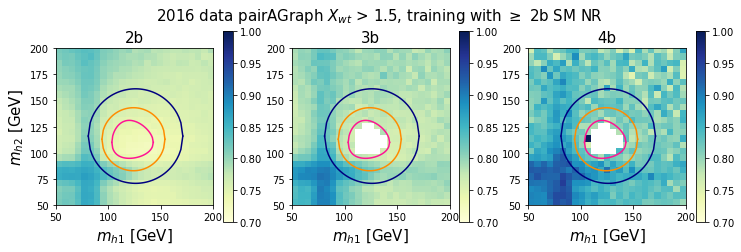

In [68]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,3.5))

# 2b
mask_2b = (bdf_2b.X_wt > 1.5) & (bdf_2b['abs_deta_hh'] < 1.5)

nb_2b,_,_,_ = binned_statistic_2d(bdf_2b.loc[mask_2b,'m_h1'], bdf_2b.loc[mask_2b,'m_h2'],
                               bdf_2b.loc[mask_2b,'max_prob'],bins=25,range=[[50,200],[50,200]])

i = ax1.imshow(nb_2b.T[::-1],cmap='YlGnBu',extent=[50,200,50,200],vmin=.7,vmax=1)
fig.colorbar(i,ax=ax1)

ax1.plot(SR_x,SR_y1,'deeppink')
ax1.plot(SR_x,SR_y2,'deeppink')
ax1.plot(CR_x,CR_y1,'darkorange')
ax1.plot(CR_x,CR_y2,'darkorange')
ax1.plot(SB_x,SB_y1,'navy')
ax1.plot(SB_x,SB_y2,'navy')

ax1.set_xlabel('$m_{h1}$ [GeV]',fontsize=15)
ax1.set_ylabel('$m_{h2}$ [GeV]',fontsize=15)
ax1.set_title('2b',fontsize=15)


# 3b
mask_3b = (bdf_4b.X_wt > 1.5) & (bdf_4b['abs_deta_hh'] < 1.5) & (bdf_4b['ntag'] == 3) & (bdf_4b.kinematic_region!=0)

nb_3b,_,_,_ = binned_statistic_2d(bdf_4b.loc[mask_3b,'m_h1'], bdf_4b.loc[mask_3b,'m_h2'],
                                  bdf_4b.loc[mask_3b,'max_prob'],bins=25,range=[[50,200],[50,200]])

i = ax2.imshow(nb_3b.T[::-1],cmap='YlGnBu',extent=[50,200,50,200],vmin=.7,vmax=1)
fig.colorbar(i,ax=ax2)

ax2.plot(SR_x,SR_y1,'deeppink')
ax2.plot(SR_x,SR_y2,'deeppink')
ax2.plot(CR_x,CR_y1,'darkorange')
ax2.plot(CR_x,CR_y2,'darkorange')
ax2.plot(SB_x,SB_y1,'navy')
ax2.plot(SB_x,SB_y2,'navy')

ax2.set_xlabel('$m_{h1}$ [GeV]',fontsize=15)
ax2.set_title('3b',fontsize=15)

# # 4b
mask_4b = (bdf_4b.X_wt > 1.5) & (bdf_4b['abs_deta_hh'] < 1.5) & (bdf_4b['ntag'] >= 4) & (bdf_4b.kinematic_region!=0)

nb_4b,_,_,_ = binned_statistic_2d(bdf_4b.loc[mask_4b,'m_h1'], bdf_4b.loc[mask_4b,'m_h2'],
                                  bdf_4b.loc[mask_4b,'max_prob'],bins=25,range=[[50,200],[50,200]])

i = ax3.imshow(nb_4b.T[::-1],cmap='YlGnBu',extent=[50,200,50,200],vmin=.7,vmax=1)
fig.colorbar(i,ax=ax3)

ax3.plot(SR_x,SR_y1,'deeppink')
ax3.plot(SR_x,SR_y2,'deeppink')
ax3.plot(CR_x,CR_y1,'darkorange')
ax3.plot(CR_x,CR_y2,'darkorange')
ax3.plot(SB_x,SB_y1,'navy')
ax3.plot(SB_x,SB_y2,'navy')

ax3.set_xlabel('$m_{h1}$ [GeV]',fontsize=15)
ax3.set_title('4b',fontsize=15)

fig.suptitle('2016 data pairAGraph $X_{wt}$ > 1.5, training with $\geq$ 2b SM NR',fontsize=15)

plt.show()

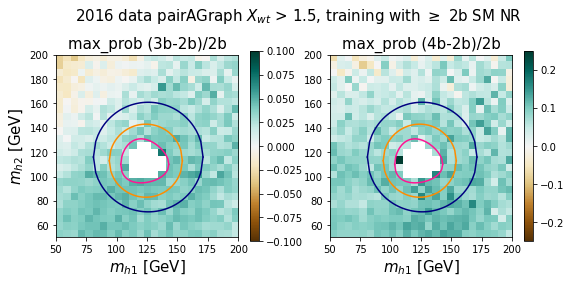

In [69]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(9,3.5))

closure_Xwt_3b = (nb_3b-nb_2b)/nb_2b
i = ax1.imshow(closure_Xwt_3b.T[::-1],cmap='BrBG',extent=[50,200,50,200],vmin=-.1,vmax=.1)
fig.colorbar(i,ax=ax1)

ax1.plot(SR_x,SR_y1,'deeppink')
ax1.plot(SR_x,SR_y2,'deeppink')
ax1.plot(CR_x,CR_y1,'darkorange')
ax1.plot(CR_x,CR_y2,'darkorange')
ax1.plot(SB_x,SB_y1,'navy')
ax1.plot(SB_x,SB_y2,'navy')

ax1.set_xlabel('$m_{h1}$ [GeV]',fontsize=15)
ax1.set_ylabel('$m_{h2}$ [GeV]',fontsize=15)
ax1.set_title('max_prob (3b-2b)/2b',fontsize=15)

closure_Xwt_4b = (nb_4b-nb_2b)/nb_2b
i = ax2.imshow(closure_Xwt_4b.T[::-1],cmap='BrBG',extent=[50,200,50,200],vmin=-.25,vmax=.25)
fig.colorbar(i,ax=ax2)

ax2.plot(SR_x,SR_y1,'deeppink')
ax2.plot(SR_x,SR_y2,'deeppink')
ax2.plot(CR_x,CR_y1,'darkorange')
ax2.plot(CR_x,CR_y2,'darkorange')
ax2.plot(SB_x,SB_y1,'navy')
ax2.plot(SB_x,SB_y2,'navy')

ax2.set_xlabel('$m_{h1}$ [GeV]',fontsize=15)
ax2.set_title('max_prob (4b-2b)/2b',fontsize=15)

fig.suptitle('2016 data pairAGraph $X_{wt}$ > 1.5, training with $\geq$ 2b SM NR',
             fontsize=15,va='bottom')

plt.show()



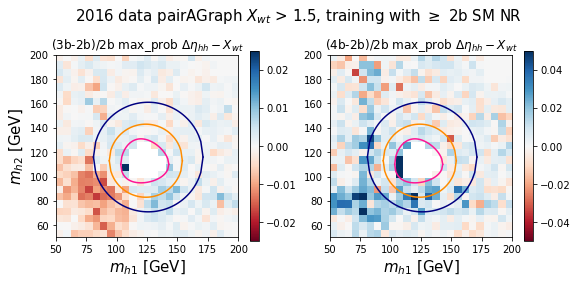

In [70]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(9,3.5))

i = ax1.imshow((closure_deta_3b-closure_Xwt_3b).T[::-1],cmap='RdBu',extent=[50,200,50,200],vmin=-.025,vmax=.025)
fig.colorbar(i,ax=ax1)

ax1.plot(SR_x,SR_y1,'deeppink')
ax1.plot(SR_x,SR_y2,'deeppink')
ax1.plot(CR_x,CR_y1,'darkorange')
ax1.plot(CR_x,CR_y2,'darkorange')
ax1.plot(SB_x,SB_y1,'navy')
ax1.plot(SB_x,SB_y2,'navy')

ax1.set_xlabel('$m_{h1}$ [GeV]',fontsize=15)
ax1.set_ylabel('$m_{h2}$ [GeV]',fontsize=15)
ax1.set_title('(3b-2b)/2b max_prob $\Delta \eta_{hh}-X_{wt}$',fontsize=12)

i = ax2.imshow((closure_deta_4b-closure_Xwt_4b).T[::-1],cmap='RdBu',extent=[50,200,50,200],vmin=-.05,vmax=.05)
fig.colorbar(i,ax=ax2)

ax2.plot(SR_x,SR_y1,'deeppink')
ax2.plot(SR_x,SR_y2,'deeppink')
ax2.plot(CR_x,CR_y1,'darkorange')
ax2.plot(CR_x,CR_y2,'darkorange')
ax2.plot(SB_x,SB_y1,'navy')
ax2.plot(SB_x,SB_y2,'navy')

ax2.set_xlabel('$m_{h1}$ [GeV]',fontsize=15)
ax2.set_title('(4b-2b)/2b max_prob $\Delta \eta_{hh}-X_{wt}$',fontsize=12)

fig.suptitle('2016 data pairAGraph $X_{wt}$ > 1.5, training with $\geq$ 2b SM NR',
             fontsize=15,va='bottom')

plt.show()



- The non-closure between the ratio of the 3b and 2b max_prob histograms stays roughly the same before and after the $X_{wt}$ cut.
- $X_{wt}$ seems to be having a bigger non-closure difference for relative 2b vs 4b than 2b vs 3b.

(This plot is pretty high-level and hard to read though.)

Also - maybe this plot should be weighted by `max_prob`??


No - I don't think so, because I'm displaying what the events are *weighted by.

Ok - that was some good R&D, but before making a *cut*, I should see how this breaks down by $m_{hh}$.

In [16]:
#### mhh_edg = np.linspace(200,1200,25)
mi = (sdf.index %2 ==0)

keys = [f'{r}_{c}_{ntag}b' for r in ['CR','VR','SR'] for c in ['deta','Xwt'] for ntag in range(2,5)]
sig_p   = {k: [] for k in keys}
sig_err = {k: [] for k in keys}

bkg_p   = {k: [] for k in keys}
bkg_err = {k: [] for k in keys}


for m_start,m_end in tqdm(zip(mhh_edg[:-1],mhh_edg[1:])):
    
    smask = (sdf.abs_deta_hh < 1.5) & (sdf.m_hh > m_start) & (sdf.m_hh < m_end) & (sdf.index%2 == 0) & sdf.trigger
    
    for r,region in enumerate(['SR','VR','CR']):
        for ntag in range(2,5):
            
            # Signal
            btag = (sdf.ntag>=4) if ntag==4 else (sdf.ntag==ntag)
            mask = smask & (sdf.kinematic_region == r) & btag
            
            key = f'{region}_deta_{ntag}b'
            
            pi = np.average(sdf.loc[mask,'max_prob'],weights=sdf.loc[mask,'mc_sf']) if np.sum(mask) > 0 else 0
            var = np.average((sdf.loc[mask,'max_prob']-pi)**2,weights=sdf.loc[mask,'mc_sf']) if np.sum(mask) > 0 else 0

            sig_p[key].append(pi)
            sig_err[key].append(np.sqrt(var))

            # Ang now after Xwt
            mask = mask & sdf.cut_Xwt 
            key = f'{region}_Xwt_{ntag}b'
            
            pi = np.average(sdf.loc[mask,'max_prob'],weights=sdf.loc[mask,'mc_sf']) if np.sum(mask) > 0 else 0
            var = np.average((sdf.loc[mask,'max_prob']-pi)**2,weights=sdf.loc[mask,'mc_sf']) if np.sum(mask) > 0 else 0

            sig_p[key].append(pi)
            sig_err[key].append(np.sqrt(var))
            
        # Background - 2b
        bmask = (bdf_2b.abs_deta_hh < 1.5) & (bdf_2b.m_hh > m_start) & (bdf_2b.m_hh < m_end) & (bdf_2b.kinematic_region == r)
        key = f'{region}_deta_2b'
        
        bkg_p[key].append( np.mean(bdf_2b.loc[bmask,'max_prob']))
        bkg_err[key].append(np.std(bdf_2b.loc[bmask,'max_prob']))
        
        bmask = bmask & bdf_2b.cut_Xwt
        key = f'{region}_Xwt_2b'
            
        bkg_p[key].append( np.mean(bdf_2b.loc[bmask,'max_prob']))
        bkg_err[key].append(np.std(bdf_2b.loc[bmask,'max_prob']))
        
        # Background 3b
        bmask = (bdf_4b.abs_deta_hh < 1.5) & (bdf_4b.m_hh > m_start) & (bdf_4b.m_hh < m_end) 
        bmask = bmask & (bdf_4b.ntag == 3) & (bdf_4b.kinematic_region == r)
        key = f'{region}_deta_3b'
            
        bkg_p[key].append( np.mean(bdf_4b.loc[bmask,'max_prob']))
        bkg_err[key].append(np.std(bdf_4b.loc[bmask,'max_prob']))
        
        bmask = bmask & bdf_4b.cut_Xwt
        key = f'{region}_Xwt_3b'
            
        bkg_p[key].append( np.mean(bdf_4b.loc[bmask,'max_prob']))
        bkg_err[key].append(np.std(bdf_4b.loc[bmask,'max_prob']))
                          
        # Background 4b
        bmask = (bdf_4b.abs_deta_hh < 1.5) & (bdf_4b.m_hh > m_start) & (bdf_4b.m_hh < m_end) 
        bmask = bmask & (bdf_4b.ntag >= 4) & (bdf_4b.kinematic_region == r)
        key = f'{region}_deta_4b'
            
        bkg_p[key].append( np.mean(bdf_4b.loc[bmask,'max_prob']))
        bkg_err[key].append(np.std(bdf_4b.loc[bmask,'max_prob']))
            
        bmask = bmask & bdf_4b.cut_Xwt
        key = f'{region}_Xwt_4b'
            
        bkg_p[key].append( np.mean(bdf_4b.loc[bmask,'max_prob']))
        bkg_err[key].append(np.std(bdf_4b.loc[bmask,'max_prob']))
                          

0it [00:00, ?it/s]


AttributeError: 'DataFrame' object has no attribute 'abs_deta_hh'

In [ ]:
xx = 0.5*(mhh_edg[:-1]+mhh_edg[1:])

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,3.5))

for ntag, ax in zip(range(2,5),[ax1,ax2,ax3]):
    
    for r,c,d in zip(['SR','VR','CR'],['deeppink','darkorange','navy'],['lightpink','gold','darkturquoise']):
        key = f'{r}_deta_{ntag}b'
        ax.errorbar(xx,sig_p[key],sig_err[key],color=c,label=f'sig {r}',
                    fmt='o',linewidth=0,elinewidth=1,markersize=2)
    
        if (r!='SR') or (ntag==2):
            ax.errorbar(xx,bkg_p[key],bkg_err[key],color=d,label=f'bkg {r}',
                        fmt='s',linewidth=0,elinewidth=1,markersize=2)    
    
        #ax.plot(mhh_edg[[0,-1]],[.85]*2,'grey',ls='--')
        
    ax.set_xlabel('$m_{hh}$ [GeV]',fontsize=15)
    ax.text(0.04,.95,f'{ntag}b',ha='left',va='top',fontsize=15,transform=ax.transAxes)
    ax.legend(loc='lower right',fontsize=11)
    ax.set_ylim((0,1.05))
    
ax1.set_ylabel('max prob',fontsize=15)  
fig.suptitle('$\Delta \eta_{hh}$ < 1.5, training with $\geq$ 2b SM NR',fontsize=15)
plt.show()

In [ ]:
xx = 0.5*(mhh_edg[:-1]+mhh_edg[1:])

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,3.5))

for ntag, ax in zip(range(2,5),[ax1,ax2,ax3]):
    
    for r,c,d in zip(['SR','VR','CR'],['deeppink','darkorange','navy'],['lightpink','gold','darkturquoise']):
        key = f'{r}_Xwt_{ntag}b'
        ax.errorbar(xx,sig_p[key],sig_err[key],color=c,label=f'sig {r}',
                    fmt='o',linewidth=0,elinewidth=1,markersize=2)
    
        if (r!='SR') or (ntag==2):
            ax.errorbar(xx,bkg_p[key],bkg_err[key],color=d,label=f'bkg {r}',
                        fmt='s',linewidth=0,elinewidth=1,markersize=2)    
    
        ax.plot(mhh_edg[[0,-1]],[.85]*2,'grey',ls='--')
        ax.set_xlim(mhh_edg[[0,-1]])
        
    ax.set_xlabel('$m_{hh}$ [GeV]',fontsize=15)
    ax.text(0.04,.95,f'{ntag}b',ha='left',va='top',fontsize=15,transform=ax.transAxes)
    ax.legend(loc='lower right',fontsize=11)
    ax.set_ylim((0,1.05))
    
ax1.set_ylabel('max prob',fontsize=15)  
fig.suptitle('$X_{wt}$ > 1.5, training with $\geq$ 2b SM NR',fontsize=15)
plt.show()

Ok - so the *main message* of these plots is that mostly `max_prob` is learning the same spectrum of $m_{hh}$.

I'll still try cutting on this, but I'm not 100% confident that this will help tbh.

In [74]:
plt.show()

np.sqrt(np.sum(s[b!=0]**2/b[b!=0]))

0.10716971213260858

In [75]:
from matplotlib import gridspec

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:27

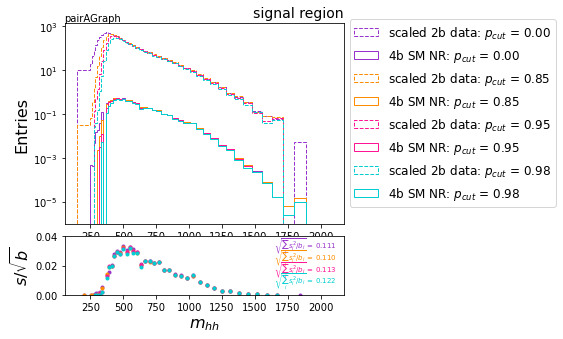

In [76]:
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(4,1)
ax1 = fig.add_subplot(gs[:3,0])
ax2 = fig.add_subplot(gs[3:,0],sharex=ax1)


for p_cut,c,yloc in zip([0,.85,.95,.98],
                        ['darkorchid','darkorange','deeppink','darkturquoise','limegreen'],
                        [1,.8,.6,.4]):

    N4b = np.sum((bdf_4b.X_wt > 1.5) & (bdf_4b.kinematic_region==2) & (bdf_4b['abs_deta_hh'] < 1.5) & (bdf_4b['max_prob'] > p_cut) & (bdf_4b.ntag>=4))
    N2b = np.sum((bdf_2b.X_wt > 1.5) & (bdf_2b.kinematic_region==2) & (bdf_2b['abs_deta_hh'] < 1.5) & (bdf_2b['max_prob'] > p_cut))
    N   = N4b / N2b

    SR_2b = (bdf_2b.X_wt > 1.5) & (bdf_2b.new_Xhh<1.6) & (bdf_2b['abs_deta_hh'] < 1.5) & (bdf_2b['max_prob'] > p_cut)

    b,_,_ = ax1.hist(bdf_2b.loc[SR_2b,'m_hh'],edges,label='scaled 2b data: $p_{cut}$ = '+f'{p_cut:.2f}',
                     weights=bdf_2b.loc[SR_2b,'max_prob']*N,log=True,
                     color=c,histtype='step',linestyle='--')

    smask = (sdf.index%2==0)&(sdf.ntag>=4)&(sdf.trigger)&(sdf.abs_deta_hh<1.5)&(sdf.X_wt>1.5)&(sdf.new_Xhh<1.6)&(sdf.max_prob > p_cut)
    s,e,_ = ax1.hist(sdf.loc[smask,'m_hh'],edges,label='4b SM NR: $p_{cut}$ = '+f'{p_cut:.2f}',
                     weights=sdf.loc[smask,'mc_sf']*sdf.loc[smask,'max_prob'],
                     color=c,histtype='step',log=True)

    sigText = '$\sqrt{\sum_i{s_i^2 / b_i}}$ = '
    ax2.plot(0.5*(edges[:-1]+edges[1:]),s/np.sqrt(b),marker='.',color=c,linewidth=0)
    ax2.text(.975,yloc,sigText+'{:.3f}'.format(np.sqrt(np.sum(s[b!=0]**2 / b[b!=0]))),
             ha='right',va='top',transform=ax2.transAxes,color=c,fontsize=7)
    
ax2.set_xlabel('$m_{hh}$',fontsize=16)

_,ymax = ax1.get_ylim()
ax1.set_ylim(0,ymax)
ax2.set_ylim(0,0.04)

ax1.set_ylabel('Entries',fontsize=16)
ax1.text(0,1,'pairAGraph',ha='left',va='bottom',transform=ax1.transAxes)
ax2.set_ylabel('$s / \sqrt{b}$',fontsize=16)

ax1.legend(fontsize=12,bbox_to_anchor=(1,1.05))

ax1.set_title('signal region', loc='right',fontsize=14)

#plt.savefig(f'figures/{subDir}/m_hh_SR_log_ratio_cf_baseline_2bCRscaled.pdf',bbox_inches='tight')

plt.show()

But, the significance was doing *quite a bit worse* than I was expecting, which begs the question of *why*.

**To try to debug this issue, I'm going to load in a few more datasets from old notebooks**

In [77]:
os.sys.path.append('../code')
from AnalysisUtils import *

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


**Files from my last pairAGraph update**

In [78]:
mc_fileName   = "../../public/hh4b/nanoNtuples/NNT_AUG19_pflow/450000_mc16a/nominal.root"
data_fileName = "../../public/hh4b/nanoNtuples/NNT_AUG19_pflow/data16_with_weights.root"

treeName = 'fullmassplane'

pflow_smnr   = nanoToDf(mc_fileName.format("pflow"),ttree=treeName)
pflow_data16 = nanoToDf(data_fileName.format("pflow"),ttree=treeName)

pflow_smnr = pflow_smnr[pflow_smnr.run_number > 296939]
pflow_smnr.loc[pflow_smnr.mc_sf < -0.002,'mc_sf'] = 0

fullmassplane
fullmassplane


In [79]:
sigSubDir = 'SMNR_mc16a_PFlow-AUG2019-5jets'
sig_df = pd.read_hdf(f"../data/{sigSubDir}/test_df_f_0.22_3b_scaledInputs_withCuts.h5", key='df')

In [80]:
fDir = f"../data/data_16_PFlow-MAY2019-{nSelectedJets}jets/"

fout = f"{fDir}df_f_0.22_NNT_HCs.h5"
df = pd.read_hdf(fout,key='df')

# Apply the cuts up to Xwt
df['deta_hh'] = np.abs(df.eta_h1-df.eta_h2)
df['cut_deta_hh'] = (df.deta_hh < 1.5) & (df.MDpT)
df['cut_Xwt'] = (df.X_wt > 1.5) & (df.cut_deta_hh)
data16 = df[df.cut_deta_hh]

In [81]:
from matplotlib import gridspec

And now load in some DL1r samples

In [84]:
SeanDir = "../../public/hh4b/bTagOptStudies/SeansFiles"

data_SR = {}

tagger = 'dl1r'
wp = 77

col = f"{tagger}_{wp}"
print(col)
rr = uproot.open(f"{SeanDir}/{tagger}/{wp}/data16_with_weights.root")

dfi = rr["fullmassplane"].pandas.df()
dfi['NN_d24_weight_16'] *= rr['NN_norm_16']._fVal
dfi['NN_d24_weight_CRderiv_16'] *= rr['NN_norm_CRderiv_16']._fVal

# For the background estimate, load in the 2b data
data_SR[col] = dfi[(dfi.kinematic_region==0)&(dfi.ntag==2)]

dl1r_77


In [85]:
fDir = "../../hh4b/bTagOpt-hh4b-resolved-reconstruction" 
    
lumi15 = 3.2195
lumi16 = 24.5556
lumi = lumi15+lumi16
lumi    
      
bdt = {}
key = f"{tagger}_{wp}"

bdt[key] = nanoToDf(f"{fDir}/bdt_{key}.root",ttree="sig")

# Just like they asked me to do last time, take out the event w/ the large negative weight
#bdt[key] = bdt[key][bdt[key]['mc_sf']>-0.002]

# Doing the luminosity normalization here as well
bdt[key]['mc_sf'] *= lumi

sig


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:53

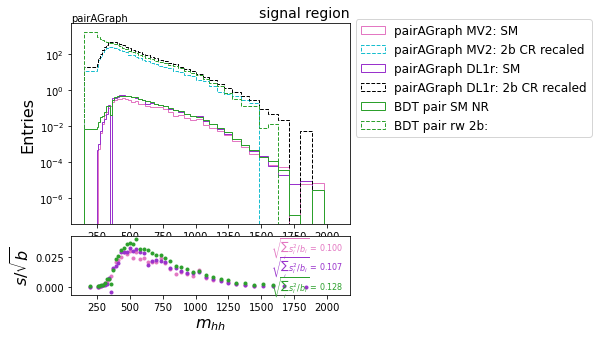

In [86]:
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(4,1)
ax1 = fig.add_subplot(gs[:3,0])
ax2 = fig.add_subplot(gs[3:,0],sharex=ax1)


# Previous pairAGraph
sig_SR = sig_df.cut_Xwt & (sig_df.kinematic_region==0) & (sig_df.ntag==4) & (sig_df.ntag==4) & sig_df.cut_deta_hh
s,_,_ = ax1.hist(sig_df.loc[sig_SR,'m_hh'],
                 edges,color='C6',histtype='step',log=True,
                 label='pairAGraph MV2: SM',
                 weights=sig_df.loc[sig_SR,'mc_sf'])

N4b = np.sum((df.kinematic_region==2) & (df.ntag>=4)&(df.cut_deta_hh))
N2b = np.sum((df.kinematic_region==2) & (df.ntag==2)&(df.cut_deta_hh))
N = N4b / N2b
bkg_SR = (df.kinematic_region==0) & (df.ntag==2) & (df.cut_deta_hh) & df.cut_Xwt
b,_,_ = ax1.hist(df.loc[bkg_SR,'m_hh'],
                 edges,color='C9',histtype='step',log=True,ls='--',
                 label='pairAGraph MV2: 2b CR recaled',
                 weights=N*np.ones(np.sum(bkg_SR)))

# New pairAGraph
smask = (sdf.index%2==0)&(sdf.ntag>=4)&(sdf.trigger) & (sdf.abs_deta_hh < 1.5) & (sdf.X_wt > 1.5) & (sdf.kinematic_region == 0)
s0,_,_ = ax1.hist(sdf.loc[smask,'m_hh'],edges,
                  label='pairAGraph DL1r: SM',
                  weights=sdf.loc[smask,'mc_sf']*sdf.loc[smask,'max_prob'],
                  color='darkorchid',histtype='step',log=True)

SR_2b = (bdf_2b.X_wt > 1.5) & (bdf_2b.kinematic_region==0) & bdf_2b.cut_deta_hh
N2b = np.sum((bdf_2b.kinematic_region==2) & (bdf_2b.abs_deta_hh < 1.5))
N4b = np.sum((bdf_4b.ntag>=4) & (bdf_4b.kinematic_region==2) & (bdf_4b.abs_deta_hh < 1.5))

N0 = N4b/N2b
b0,_,_ = ax1.hist(bdf_2b.loc[SR_2b,'m_hh'],edges,
                  label='pairAGraph DL1r: 2b CR recaled',
                  weights=N0*bdf_2b.loc[SR_2b,'max_prob'],log=True,
                  color='k',histtype='step',linestyle='--')

# BDT pairing
s1,_,_ = ax1.hist(bdt[key].loc[bdt[key].ntag>=4,'m_hh'],
                  edges,color='C2',histtype='step',log=True,
                  label="BDT pair SM NR",
                  weights=bdt[key].loc[bdt[key].ntag>=4,'mc_sf'])

b1,_,_ = ax1.hist(data_SR[key]['m_hh'],
                  edges,color='C2',histtype='step',log=True,
                  label="BDT pair rw 2b:",ls='--',
                  weights=data_SR[key]['NN_d24_weight_16'])

ax2.plot(0.5*(edges[:-1]+edges[1:]),s/np.sqrt(b),marker='.',color='C6',linewidth=0)
ax2.plot(0.5*(edges[:-1]+edges[1:]),s0/np.sqrt(b0),marker='.',color='darkorchid',linewidth=0)
ax2.plot(0.5*(edges[:-1]+edges[1:]),s1/np.sqrt(b1),marker='.',color='C2',linewidth=0)
ax2.set_xlabel('$m_{hh}$',fontsize=16)
#ax2.set_ylim(0,.04)

_,ymax = ax1.get_ylim()
ax1.set_ylim(0,ymax)

ax1.set_ylabel('Entries',fontsize=16)
ax1.text(0,1,'pairAGraph',ha='left',va='bottom',transform=ax1.transAxes)

sigText = '$\sqrt{\sum_i{s_i^2 / b_i}}$ = '

ax2.text(.975,1,
         sigText+'{:.3f}'.format(np.sqrt(np.sum(s[b!=0]**2 / b[b!=0]))),
         ha='right',va='top',transform=ax2.transAxes,color='C6',fontsize=8)
ax2.text(.975,.675,
         sigText+'{:.3f}'.format(np.sqrt(np.sum(s0[b0!=0]**2 / b0[b0!=0]))),
         ha='right',va='top',transform=ax2.transAxes,color='darkorchid',fontsize=8)
ax2.text(.975,.35,
         sigText+'{:.3f}'.format(np.sqrt(np.sum(s1[b1!=0]**2 / b1[b1!=0]))),
         ha='right',va='top',transform=ax2.transAxes,color='C2',fontsize=8)

ax2.set_ylabel('$s / \sqrt{b}$',fontsize=16)

#ax1.legend(fontsize=10,loc="upper right")
ax1.legend(fontsize=12,bbox_to_anchor=(1,1.05))

ax1.set_title('signal region', loc='right',fontsize=14)

#plt.savefig(f'figures/{subDir}/m_hh_SR_log_ratio_cf_baseline_2bCRscaled.pdf',bbox_inches='tight')

plt.show()

In [87]:
np.sum(b),np.sum(b0),np.sum(b1)

(2757.5781605450297, 5336.261638407454, 9216.658526317218)

In [88]:
N0

0.008902197568970016

In [89]:
np.sum(s)

4.055189573291652

In [90]:
np.sum(sig_df.loc[sig_SR&sig_df.cut_deta_hh,'mc_sf'])

4.05518957329163

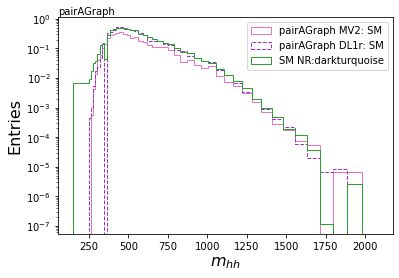

In [91]:
sig_SR = sig_df.cut_deta_hh & sig_df.cut_Xwt &  (sig_df.kinematic_region==0) & (sig_df.ntag==4)
s,_,_ = plt.hist(sig_df.loc[sig_SR,'m_hh'],
                 edges,color='C6',histtype='step',log=True,
                 label='pairAGraph MV2: SM',
                 weights=sig_df.loc[sig_SR,'mc_sf'])

smask = (sdf.index%2==0)&(sdf.ntag>=4)&(sdf.trigger) & (sdf.abs_deta_hh < 1.5) & (sdf.X_wt > 1.5) & (sdf.kinematic_region == 0)
s0,_,_ = plt.hist(sdf.loc[smask,'m_hh'],edges,
                  label='pairAGraph DL1r: SM',linestyle='--',
                  weights=sdf.loc[smask,'mc_sf']*sdf.loc[smask,'max_prob'],
                  color='darkorchid',histtype='step',log=True)

s1,_,_ = plt.hist(bdt[key].loc[bdt[key].ntag>=4,'m_hh'],
                  edges,color='C2',histtype='step',log=True,
                  label="SM NR:"+c.replace("_"," "),ls='-',
                  weights=bdt[key].loc[bdt[key].ntag>=4,'mc_sf'])

plt.xlabel('$m_{hh}$',fontsize=16)
plt.ylabel('Entries',fontsize=16)
ax1=plt.gca()
plt.text(0,1,'pairAGraph',ha='left',va='bottom',transform=ax1.transAxes)
plt.legend()
plt.show()

Alright - so in terms of *efficiency* they're doing pretty much comparably, but rn pairAGraph is *sucking* in term of background rejection for $m_{hh}$

**Issue:** My newly trained pairAGraph is performing *worse* in terms of the background rejection for $m_{hh}$.

Maybe before I wasn't seeing this come up just because I wasn't including 2b in the training, but I think this is a good point now to dig into *why* this is.

**Step 1:** Compare the *ratios* of the $(m_{h1},m_{h2})$ planes w/ and w/o training with 2b.

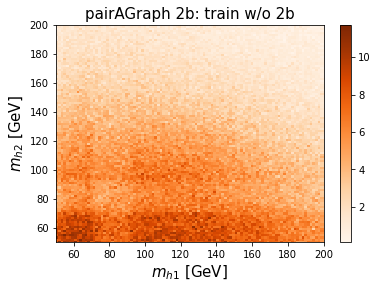

In [92]:
plt.figure()

bkg_all = (df.ntag==2) & (df.cut_deta_hh) & df.cut_Xwt
n,_,_,_ = plt.hist2d(df.loc[bkg_all,'m_h1'],df.loc[bkg_all,'m_h2'],
                     100,[[50,200],[50,200]],cmap='Oranges',
                     weights=N*np.ones(np.sum(bkg_all)))

plt.colorbar()
plt.xlabel('$m_{h1}$ [GeV]',fontsize=15)
plt.ylabel('$m_{h2}$ [GeV]',fontsize=15)
plt.title('pairAGraph 2b: train w/o 2b',fontsize=15)
plt.show()

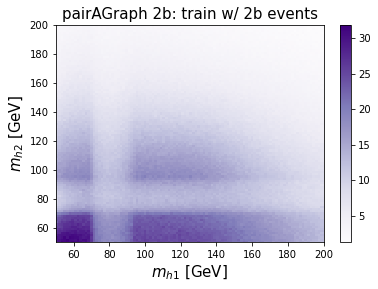

In [93]:
plt.figure()

all_2b = (bdf_2b.X_wt > 1.5) & (bdf_2b['abs_deta_hh'] < 1.5)
n0,_,_,_ = plt.hist2d(bdf_2b.loc[all_2b,'m_h1'],bdf_2b.loc[all_2b,'m_h2'],
                      100,[[50,200],[50,200]],cmap='Purples',
                      weights=N0*np.ones(np.sum(all_2b)))

plt.colorbar()
plt.xlabel('$m_{h1}$ [GeV]',fontsize=15)
plt.ylabel('$m_{h2}$ [GeV]',fontsize=15)
plt.title('pairAGraph 2b: train w/ 2b events',fontsize=15)

plt.show()

There are *a lot* more 2b events passing through when we train with 2b included.

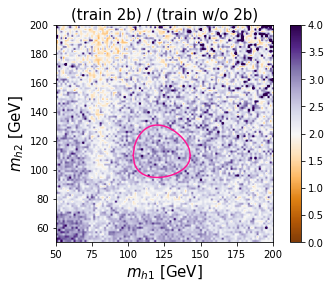

In [94]:
plt.imshow((n0/n).T[::-1],cmap='PuOr',extent=[50,200,50,200],vmin=0,vmax=4)
cbar = plt.colorbar()
plt.title('(train 2b) / (train w/o 2b)',fontsize=15)
plt.xlabel('$m_{h1}$ [GeV]',fontsize=15)
plt.ylabel('$m_{h2}$ [GeV]',fontsize=15)

plt.plot(SR_x,SR_y1,'deeppink')
plt.plot(SR_x,SR_y2,'deeppink')

plt.show()

- Ok - but this isn't *really* the right plot though - I need training w/o 2b but **DL1r**.
- Depending no how this plot comes out though, I might also need to test if training before the trigger is fucking me up?

I guess I was more just trying to understand what made the background get out-of hand?

In [95]:
np.sum(b0) / np.sum(b)

1.9351261606136134

About 3x more events, this is consistent with what was expected from the $m_{hh}$ spectrum.

So this could be due to 
1. $b$-tagging getting better
2. 2b letting more events in 
3. My decision to train with the trigger

(And my bet is on #2)

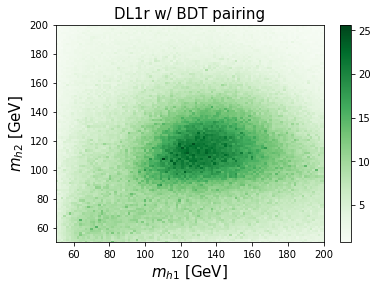

In [96]:
plt.figure()

n2,_,_,_ = plt.hist2d(dfi.loc[dfi.ntag==2,'m_h1'],dfi.loc[dfi.ntag==2,'m_h2'],
                      100,[[50,200],[50,200]],cmap='Greens',
                      weights=dfi.loc[dfi.ntag==2,'NN_d24_weight_16'])

plt.colorbar()
plt.xlabel('$m_{h1}$ [GeV]',fontsize=15)
plt.ylabel('$m_{h2}$ [GeV]',fontsize=15)
plt.title('DL1r w/ BDT pairing',fontsize=15)

plt.show()

In [97]:
np.sum(dfi.loc[(dfi.ntag==2)&(dfi.kinematic_region==0),'NN_d24_weight_16'])

9216.658526317193

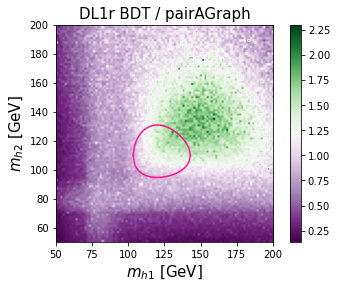

In [98]:
plt.imshow((n2/n0).T[::-1],cmap='PRGn',extent=[50,200,50,200])#,vmin=0,vmax=10)
cbar = plt.colorbar()
plt.title('DL1r BDT / pairAGraph',fontsize=15)
plt.xlabel('$m_{h1}$ [GeV]',fontsize=15)
plt.ylabel('$m_{h2}$ [GeV]',fontsize=15)

plt.plot(SR_x,SR_y1,'deeppink')
plt.plot(SR_x,SR_y2,'deeppink')
plt.show()

Ok - this plot makes sense.

The extra events that pairAGraph has at low $(m_{h1},m_{h2})$ is why it's picking up more high $m_{hh}$ events.

### 3. Splitting trainings based on event number <a name="splitEvts"></a>




### 4. Number of jets <a name="njets"></a>


### 5. Different physics samples <a name="physicsSamples"></a>
